# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import os
import pandas as pd
import random
import json
import cv2
import math
import pydicom as dicomio

from pydicom import dcmread
from scipy import ndimage
from skimage.util import montage
from skimage.measure import label, regionprops, find_contours
from skimage.morphology import disk, binary_dilation, binary_opening

In [3]:
%run utils.ipynb

# Load Data

In [3]:
exam_id = 50
EXAMS_DIR = "/Storage/PauloOctavioDir/Exames/"
IMAGES_DIR = f"/Storage/PauloOctavioDir/Exames/{exam_id}/dicomRT/Original-dcm"
MASKS_DIR = f"/Storage/PauloOctavioDir/Exames/{exam_id}/Segmentado/dcm"

In [286]:
for exam in os.listdir(EXAMS_DIR):
    image_dir = f"/Storage/PauloOctavioDir/Exames/{exam}/dicomRT/Original-dcm/"
    data = dcmread(image_dir + os.listdir(image_dir)[1])
    if int(data.RescaleIntercept) != -1024 or int(data.RescaleSlope) != 1:
        print(data.RescaleIntercept, data.RescaleSlope)

In [40]:
max_values = {}
min_values = {}
for exam in os.listdir(EXAMS_DIR):
    image_dir = f"/Storage/PauloOctavioDir/Exames/{exam}/dicomRT/Original-dcm/"
    data = dcmread(image_dir + os.listdir(image_dir)[1])
    image = data.pixel_array
    intercept = int(data.RescaleIntercept)
    slope = int(data.RescaleSlope)
    image = slope * image + intercept
    max_values[exam] = image.max()
    min_values[exam] = image.min()
print(dict(sorted(max_values.items(), key=lambda item: item[1])))
print(dict(sorted(min_values.items(), key=lambda item: item[1])))

{'36': 795, '8': 905, '78': 954, '15': 966, '26': 1006, '10': 1014, '46': 1036, '6': 1046, '56': 1061, '73': 1068, '52': 1094, '23': 1096, '37': 1103, '16': 1103, '38': 1105, '19': 1109, '49': 1112, '76': 1115, '39': 1127, '40': 1128, '25': 1136, '34': 1148, '12': 1152, '7': 1153, '27': 1154, '28': 1154, '17': 1168, '75': 1169, '2': 1170, '29': 1172, '72': 1177, '32': 1197, '11': 1200, '4': 1203, '71': 1204, '66': 1206, '50': 1208, '18': 1217, '42': 1225, '24': 1229, '77': 1236, '43': 1243, '5': 1245, '30': 1253, '14': 1260, '33': 1261, '41': 1275, '47': 1276, '13': 1277, '80': 1278, '79': 1292, '67': 1297, '9': 1323, '54': 1331, '35': 1333, '31': 1333, '1': 1346, '45': 1369, '44': 1419, '53': 1432, '22': 1437, '69': 1460, '70': 1529, '48': 1552, '3': 1594, '20': 1768, '21': 2326, '65': 2976}
{'78': -3024, '72': -3024, '75': -3024, '50': -3024, '79': -2048, '19': -2048, '25': -2048, '52': -1024, '10': -1024, '69': -1024, '73': -1024, '49': -1024, '35': -1024, '45': -1024, '46': -1024, 

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.274.1.1.8323329.23967.1655243018.190885
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.5
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_365'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20220614'
(0008, 0013) Instance Creation Time              TM: '184335'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.274.

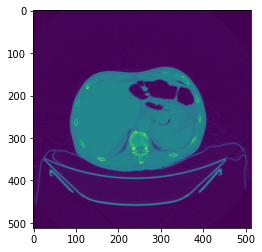

In [4]:
# Image DICOM content example
image_dir = f"/Storage/PauloOctavioDir/Exames/1/dicomRT/Original-dcm/IMG0080.dcm"
data = dcmread(image_dir)
print(data)
plt.imshow(data.pixel_array)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 254
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.41004064468589793483504692546856897
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.5.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.5'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 5.1.2'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1.41004064468589793483504

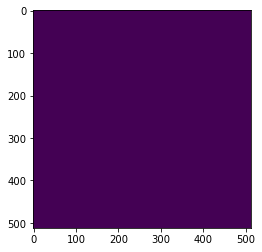

In [63]:
mask_dir = f"/Storage/PauloOctavioDir/Exames/1/Segmentado/dcm/IMG0080.dcm"
data = dcmread(mask_dir)
print(data)
plt.imshow(data.pixel_array)

# Exploratory Data Analysis


In [3]:
MIN_HU_VALUE = -1000
MAX_HU_VALUE = 400

In [4]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = -1024
    slope = 1
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
# Load the scans in given folder path
def load_exam(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path) if s != 'rtss.dcm']
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    volume = get_pixels_hu(slices)  
    return volume

def load_mask(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path) if s != 'rtss.dcm']
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    volume = np.stack([s.pixel_array for s in slices])
    return np.array(volume, dtype=np.int16)

def get_volumes(images_path, masks_path, exam_id):
    root_path = EXAMS_DIR + str(exam_id)
    exam = load_exam(root_path + images_path)
    masks = load_mask(root_path + masks_path)
    return exam, masks

exam, masks_vol = get_volumes('/dicomRT/Original-dcm', '/Segmentado/dcm', exam_id)

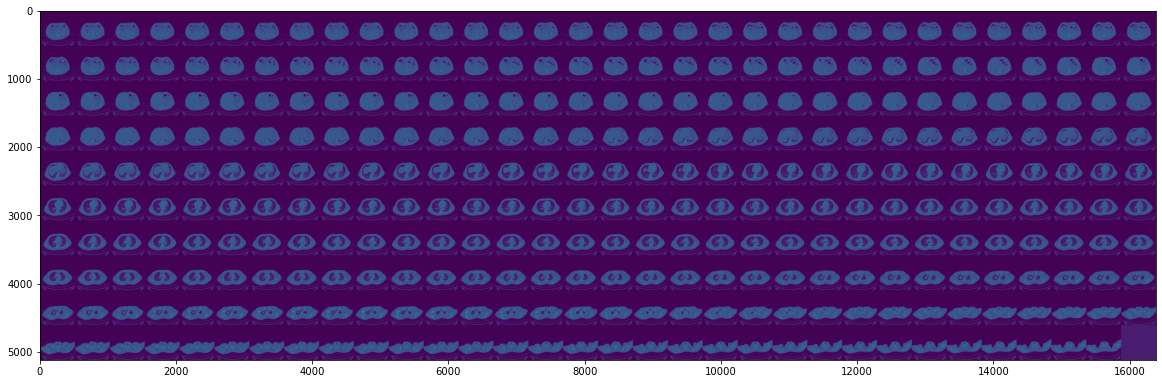

In [6]:
def print_montage(volume, cmap=None, div=10):
    no_cols = np.ceil(volume.shape[0] / div).astype(int)
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
    ax1.imshow(montage(volume, grid_shape=(div,no_cols)), cmap)

print_montage(exam)

In [7]:
def normalize(volume):
    """Normalize the volume"""
    min = MIN_HU_VALUE
    max = MAX_HU_VALUE
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume

In [8]:
# What are the mask values?
np.unique(masks_vol)

array([0, 1], dtype=int16)

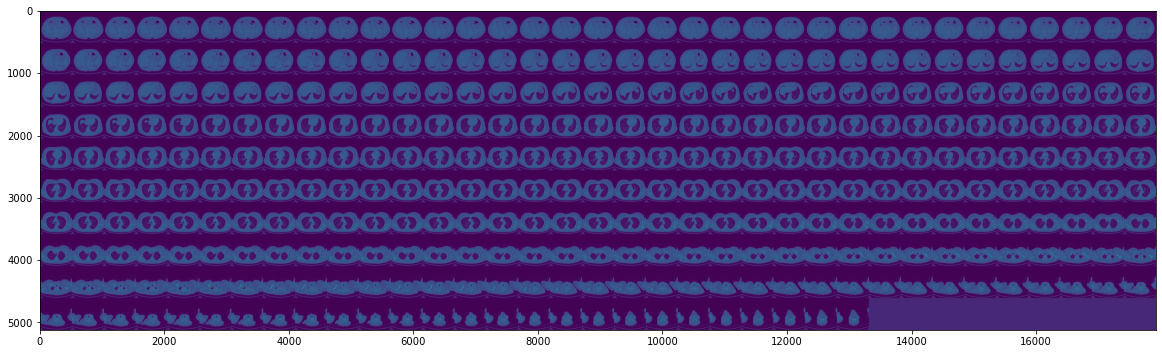

In [9]:
def get_volume(exam_id):
    volume = []
    exam_dir = f'/Storage/PauloOctavioDir/Exames/{exam_id}/dicomRT/Original-dcm/'
    images = os.listdir(exam_dir)
    images.sort()
    for image in images:
        if image != 'rtss.dcm':
            data = dcmread(exam_dir + image).pixel_array
            volume.append(data)
    return np.asarray(volume)
volume = get_volume(10)
print_montage(volume)

In [10]:
# What is the data type of the images?
volume.dtype

dtype('int16')

In [ ]:
# What are the first non-zero pixels in all directions?

TRAIN_DIR = f"/Storage/PauloOctavioDir/nodule_images/images"

non_zero_pos = {}
for img_file in TRAIN_DIR:
    non_zero_pos[img_file] = {}
    img = dcmread(TRAIN_DIR + img_file).pixel_array
    positions = np.nonzero(img)
    non_zero_pos[img_file]["top"] = positions[0].min()
    non_zero_pos[img_file]["bottom"] = positions[0].max()
    non_zero_pos[img_file]["left"] = positions[1].min()
    non_zero_pos[img_file]["right"] = positions[1].max()

In [13]:
def crop_image(image, left, top, right, bottom):
    croped_image = image[top:-bottom,
                left:-right]
    return croped_image

In [14]:
for image in slices_with_nodule:
    if image in images:
        image_data = dcmread(IMAGES_DIR + '/' + image).pixel_array
        mask_data = dcmread(MASKS_DIR + '/' + image).pixel_array
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].imshow(crop_image(image_data, 75, 200, 50, 75))
        ax[1].imshow(crop_image(mask_data, 75, 200, 50, 75))
        plt.show()

NameError: name 'slices_with_nodule' is not defined

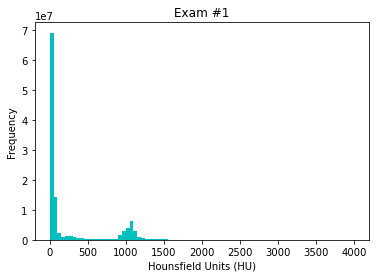

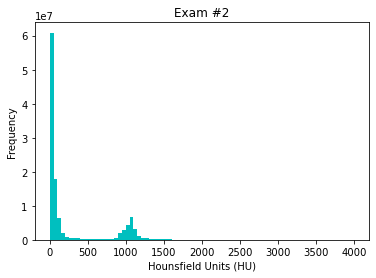

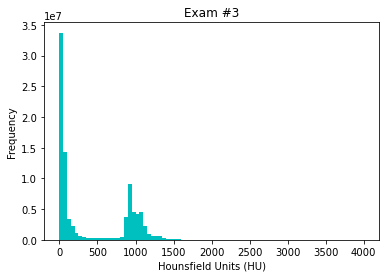

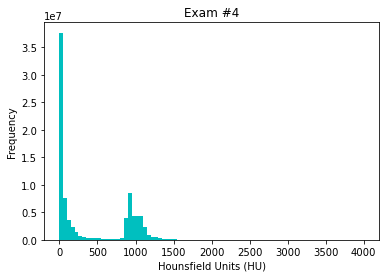

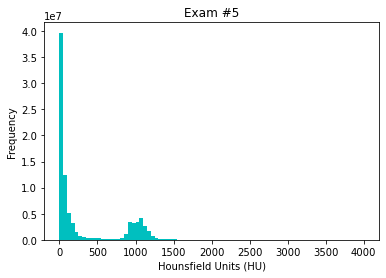

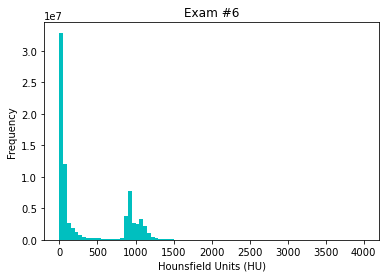

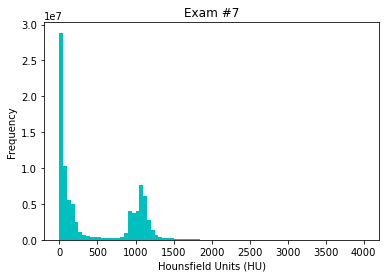

KeyboardInterrupt: 

In [15]:
for exam_id in range(1,10):
    volume = get_volume(exam_id)
    plt.hist(np.concatenate(volume, axis=None), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.title(f"Exam #{exam_id}")
    plt.show()

In [16]:
exams = os.listdir(EXAMS_DIR)
df_list = []
for exam_id in exams:
    volume = get_volume(exam_id)
    vol_arr = np.concatenate(volume, axis=None)
    df_list.append(
        {
            'Id': exam_id,
            'Number of Slices': volume.shape[0],
            'Min': vol_arr.min(),
            'Max': vol_arr.max(),
            'Mean': vol_arr.mean(),
            'Std': vol_arr.std()
        }
    )
exams_df = pd.DataFrame(df_list)
exams_df = exams_df.set_index('Id')
no_slices = exams_df['Number of Slices']
print(f"Number of Slices Statistics: \n\tMin = {no_slices.min()}, Max = {no_slices.max()}, Mean = {no_slices.mean()}")
exams_df.head()

KeyboardInterrupt: 

In [ ]:
# Source: https://github.com/nikhilroxtomar/Semantic-Segmentation-Mask-to-Bounding-Box/blob/main/mask_to_bbox.py
def mask_to_border(mask):
    """ Convert a mask to border image """
    border = np.zeros(mask.shape)
    contours = find_contours(mask, 0.5)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])   
            border[x][y] = 255
    return border


def mask_to_bbox(mask):
    """ Mask to bounding boxes """
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes

""" Detecting bounding boxes """
bboxes = mask_to_bbox(mask_data)

""" Marking bounding box on image """
for bbox in bboxes:
    x = cv2.rectangle(image_data, (bbox[0], bbox[1]), (bbox[2], bbox[3]), 2000, 1)

plt.imshow(x)

# Lung Neoplasm Dataset

In [33]:
df = pd.read_csv('data/lung_neoplasm_database_cleaned.csv', dtype=object)
df.head()

REG EXAME DATA NASCIMENTO SEXO TABAGISMO PREGRESSO     DATA TC TECNICA TC  \
0         1       8/19/1947    1                   X    3/2/2017          1   
1         2       1/25/1946    1                   X  26/10/2015          1   
2         3       7/30/1942    2                   X   14/3/2016          1   
3         4       6/28/1952    2                   X   21/2/2017          1   
4         5       2/12/1943    1                   X   3/10/2012          1   

  LOBO DA LESÃO POSIÇÃO DA LESÃO MAIOR DIÂMETRO ESTADIO T ESTADIO N ESTADIO M  \
0             3                2             30        2a         0        1c   
1             5                2             23        1b         0        1c   
2             1                2             11        1a         0         0   
3             1                2             16        1a         3         0   
4             4                2             36        2a         1         0   

  DATA 1o DIAGN PATOLÓGICO TIPO PATOLOGIA (FINAL) TIPO HISTOLÓGICO  \
0                 8/2/2017                    NaN                2   
1                8/12/2015                      2                2   
2                13/4/2016                      2                2   
3                22/2/2017                    NaN                3   
4                19/9/2012                      3                5   

  DATA PROGRESSÃO DOENÇA LOCAL DA PROGRESSÃO  
0                    NaN                 NaN  
1              29/6/2016                   1  
2              7/18/2017             5, 8, 6  
3              5/29/2018                1, 9  
4              18/5/2016                   1

In [34]:
with open('colunmns_description.json') as json_file:
    colunmns_description = json.load(json_file)
    print(colunmns_description)

{'REG EXAME': nan, 'DATA NASCIMENTO': 'dd/mm/aaaa', 'SEXO': '1- masc, 2- fem', 'TABAGISMO ATUAL': '0- ausente, X anos-maço se presente', 'TABAGISMO PREGRESSO': '0- ausente, X anos-maço se presente', 'DATA TC': 'dd/mm/aaaa', 'TECNICA TC': '1- MDTC contraste, 2- MDTC sem contraste, 3- outra', 'LOBO DA LESÃO': '1- LSD, 2- LM, 3- LID, 4- LSE, 5- Lin, 6- LIE', 'POSIÇÃO DA LESÃO': '1- central, 2- periférica', 'MAIOR DIÂMETRO': 'mm', 'ESTADIO T': '1a, 1b, 1c, 2a, 2b, 3, 4', 'ESTADIO N': '0, 1, 2, 3', 'ESTADIO M': '0, 1a, 1b, 1c', 'DATA 1o DIAGN PATOLÓGICO': 'dd/mm/aaaa', 'TIPO PATOLOGIA (FINAL)': '1- biópsia transbrônquica, 2- biópsia percutânea, 3- cirurgia', 'TIPO HISTOLÓGICO': '1- SCLC, 2- NSCLC adeno, 3- NSCLC escamoso, 4- NSCLC adenoescamoso, 5- Large cell, 6- carcinoide típico, 7- carcinoide atípico, 8- NSCLC indiferenciado, 9- outro', 'DATA PROGRESSÃO DOENÇA': nan, 'LOCAL DA PROGRESSÃO': '1- pulmão, 2- mediastino, 3- pleura, 4- adrenal, 5- fígado, 6- osso, 7- SNC, 8- rim, 9- outro'}


In [35]:
# replace codes for values
categorical_cols = [
    'SEXO', 'TECNICA TC','LOBO DA LESÃO','POSIÇÃO DA LESÃO','TIPO PATOLOGIA (FINAL)',
    'TIPO HISTOLÓGICO'
]
cat_cols_dict = {}
for col in categorical_cols:
    cat_cols_dict[col] = {
        i.split('-')[0].strip():i.split('-')[1].strip() for i in colunmns_description[col].split(',')
    }
    
for key,value in cat_cols_dict.items():
    df = df.replace({key:value})

In [36]:
date_cols = ['DATA NASCIMENTO', 'DATA TC', 'DATA 1o DIAGN PATOLÓGICO', 'DATA PROGRESSÃO DOENÇA', ]
df[date_cols] = df[date_cols].apply(pd.to_datetime)

In [37]:
df.head()

REG EXAME DATA NASCIMENTO  SEXO TABAGISMO PREGRESSO    DATA TC  \
0         1      1947-08-19  masc                   X 2017-03-02   
1         2      1946-01-25  masc                   X 2015-10-26   
2         3      1942-07-30   fem                   X 2016-03-14   
3         4      1952-06-28   fem                   X 2017-02-21   
4         5      1943-02-12  masc                   X 2012-03-10   

       TECNICA TC LOBO DA LESÃO POSIÇÃO DA LESÃO MAIOR DIÂMETRO ESTADIO T  \
0  MDTC contraste           LID       periférica             30        2a   
1  MDTC contraste           Lin       periférica             23        1b   
2  MDTC contraste           LSD       periférica             11        1a   
3  MDTC contraste           LSD       periférica             16        1a   
4  MDTC contraste           LSE       periférica             36        2a   

  ESTADIO N ESTADIO M DATA 1o DIAGN PATOLÓGICO TIPO PATOLOGIA (FINAL)  \
0         0        1c               2017-08-02                    NaN   
1         0        1c               2015-08-12     biópsia percutânea   
2         0         0               2016-04-13     biópsia percutânea   
3         3         0               2017-02-22                    NaN   
4         1         0               2012-09-19               cirurgia   

  TIPO HISTOLÓGICO DATA PROGRESSÃO DOENÇA LOCAL DA PROGRESSÃO  
0      NSCLC adeno                    NaT                 NaN  
1      NSCLC adeno             2016-06-29                   1  
2      NSCLC adeno             2017-07-18             5, 8, 6  
3   NSCLC escamoso             2018-05-29                1, 9  
4       Large cell             2016-05-18                   1

In [38]:
df.to_csv('data/lung_neoplasm_database_cleaned_ds.csv')

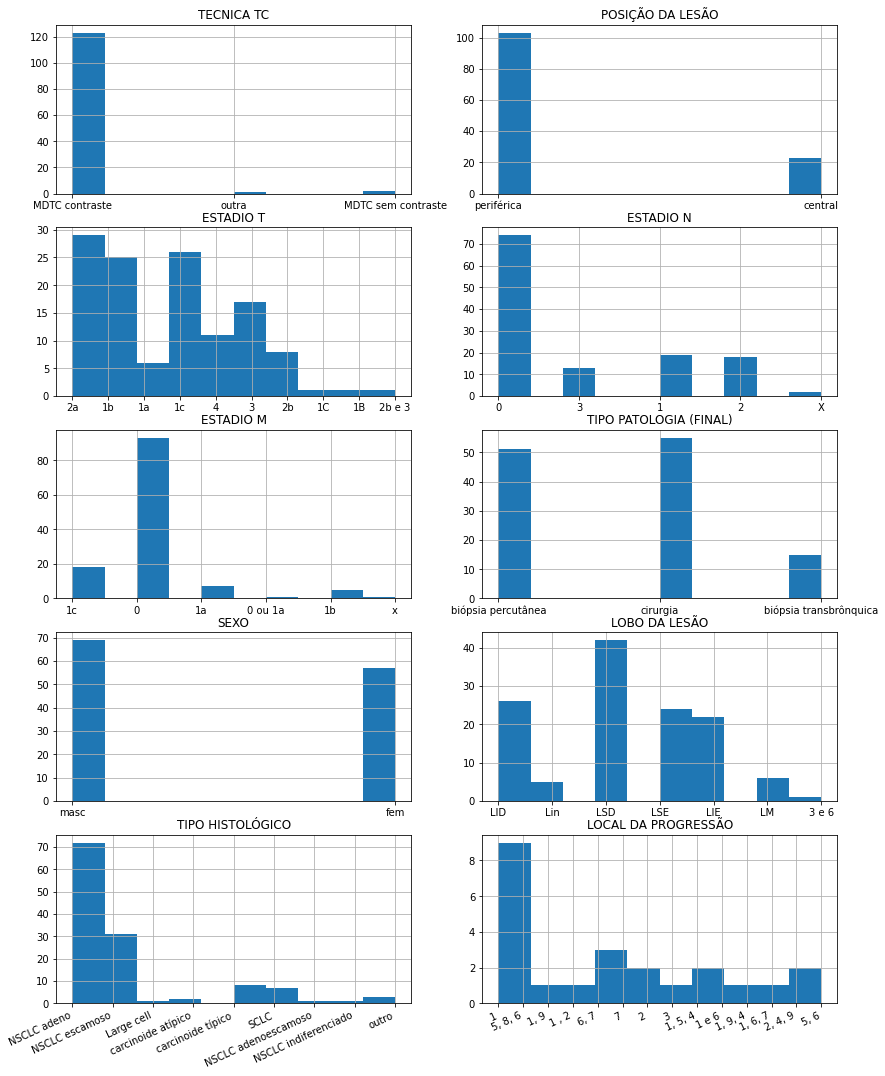

In [39]:
features = [
    'TECNICA TC', 'POSIÇÃO DA LESÃO', 'ESTADIO T', 'ESTADIO N', 'ESTADIO M', 'TIPO PATOLOGIA (FINAL)',
    'SEXO', 'LOBO DA LESÃO','TIPO HISTOLÓGICO','LOCAL DA PROGRESSÃO'
]
no_rows = 5
no_cols = 2
fig, ax = plt.subplots(no_rows, no_cols, figsize=(14, 18))

for i in range(no_rows):
    for j in range(no_cols):
        m = no_cols * i + j
        df[features[m]].hist(ax=ax[i,j]).set_title(features[m])
        
plt.setp(ax[no_rows - 1,0].get_xticklabels(), rotation=25, ha='right')
plt.setp(ax[no_rows - 1,1].get_xticklabels(), rotation=25, ha='right')
plt.show()

In [40]:
df[(df['ESTADIO N'] == 'X') | (df['ESTADIO M'] == 'X')]

REG EXAME DATA NASCIMENTO SEXO TABAGISMO PREGRESSO    DATA TC  \
81        84      1957-12-17  fem                   X 2016-03-08   
84        87      1960-01-07  fem                   X 2016-09-29   

        TECNICA TC LOBO DA LESÃO POSIÇÃO DA LESÃO MAIOR DIÂMETRO ESTADIO T  \
81  MDTC contraste           LSD       periférica             16        1a   
84  MDTC contraste           LSE          central             41        2b   

   ESTADIO N ESTADIO M DATA 1o DIAGN PATOLÓGICO  TIPO PATOLOGIA (FINAL)  \
81         X         x               2016-09-28      biópsia percutânea   
84         X        1a               2016-08-24  biópsia transbrônquica   

   TIPO HISTOLÓGICO DATA PROGRESSÃO DOENÇA LOCAL DA PROGRESSÃO  
81      NSCLC adeno                    NaT                 NaN  
84   NSCLC escamoso             2017-08-08                   1

In [41]:
df[(df['ESTADIO T'] == '2b e 3') | (df['ESTADIO M'] == '0 ou 1a')]

REG EXAME DATA NASCIMENTO SEXO TABAGISMO PREGRESSO    DATA TC  \
49          50      1955-02-02  fem                   X 2016-09-29   
125  126 e 127      1961-03-02  fem                   X 2018-05-21   

             TECNICA TC LOBO DA LESÃO POSIÇÃO DA LESÃO MAIOR DIÂMETRO  \
49       MDTC contraste           LIE       periférica             27   
125  MDTC sem contraste         3 e 6       periférica        48 e 57   

    ESTADIO T ESTADIO N ESTADIO M DATA 1o DIAGN PATOLÓGICO  \
49         1c         1   0 ou 1a               2016-11-16   
125    2b e 3         3        1a               2018-05-30   

    TIPO PATOLOGIA (FINAL) TIPO HISTOLÓGICO DATA PROGRESSÃO DOENÇA  \
49      biópsia percutânea      NSCLC adeno                    NaT   
125     biópsia percutânea   NSCLC escamoso                    NaT   

    LOCAL DA PROGRESSÃO  
49                  NaN  
125                 NaN

In [42]:
# Examples of Adenocarcinoma
adeno = df[df['TIPO HISTOLÓGICO'] == 'NSCLC adeno']['REG EXAME'].tolist()
print(f'Adenocarcinoma: {adeno}\n')

# Examples of Squamous cell carcinoma
squamous = df[df['TIPO HISTOLÓGICO'] == 'NSCLC escamoso']['REG EXAME'].tolist()
print(f'Squamous cell carcinoma: {squamous}')

Adenocarcinoma: ['1', '2', '3', '7', '8', '9', '11', '12', '14', '16', '17', '19', '20', '21', '22', '25', '26', '27', '31', '33', '34', '36', '39', '41', '42', '43', '44', '45', '46', '47', '48', '50', '53', '54', '56', '57', '58', '60', '61', '63', '64', '65', '67', '70', '72', '73', '75', '76', '77', '78', '80', '83', '84', '85', '86', '88', '92', '93', '95', '98', '104', '106', '109', '110', '111', '112', '113', '117', '118', '122', '123', '129']

Squamous cell carcinoma: ['4', '6', '13', '15', '18', '23', '28', '29', '35', '37', '51', '59', '62', '66', '69', '71', '74', '81', '87', '89', '91', '94', '96', '100', '102', '103', '107', '114', '120', '125', '126 e 127']


# Nodules ROI

In [4]:
def crop_roi(image, left, top, right, bottom):
    croped_image = image[top:bottom,
                left:right]
    return croped_image

def mask_to_bbox(mask):
    # ref: https://github.com/nikhilroxtomar/Semantic-Segmentation-Mask-to-Bounding-Box/blob/main/mask_to_bbox.py
    lbl = label(mask)
    props = regionprops(lbl)
    if len(props) == 0:
        raise ValueError('No mask identified.')
    if len(props) == 1:
        prop = props[0]
    else:
        areas = [r.area for r in props]
        areas.sort()
        for region in props:
            if region.area == areas[-1]:
                prop = region
    x1 = prop.bbox[1]
    y1 = prop.bbox[0]
    x2 = prop.bbox[3]
    y2 = prop.bbox[2]
    bbox = [x1, y1, x2, y2]
    return bbox

def mask_to_roi(mask, image, bbox_extension=0):
    
    bboxes = mask_to_bbox(mask)
    cropped_image = crop_roi(
        image, 
        bboxes[0] - bbox_extension, 
        bboxes[1] - bbox_extension, 
        bboxes[2] + bbox_extension, 
        bboxes[3] + bbox_extension
    )
    
    return cropped_image

slice_idx = 112
mask = masks_vol[112]
image = exam[112]
cropped_image = mask_to_roi(mask, image)
show_image_list([image, mask, cropped_image],
                ['Image', 'Mask', 'Nodule RoI']
                , num_cols = 3)

NameError: name 'masks_vol' is not defined

## Statistical Analysis of Nodule Sizes

In [5]:
def get_pixel_array(dicom_file):
    data = dcmread(dicom_file)
    return data.pixel_array

def get_image_resolution(bbox):
    w = bbox[2] - bbox[0]  
    h = bbox[3] - bbox[1] 
    return round(math.sqrt(w * h), 0)

def get_pixels_hu(image, slope=1, intercept=-1024):
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)    
    image = image * slope + np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

### HCRP

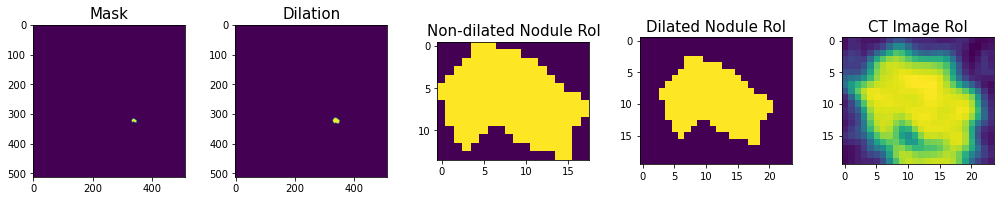

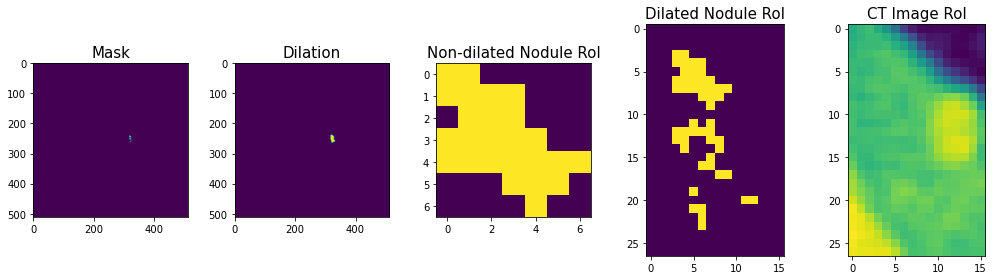

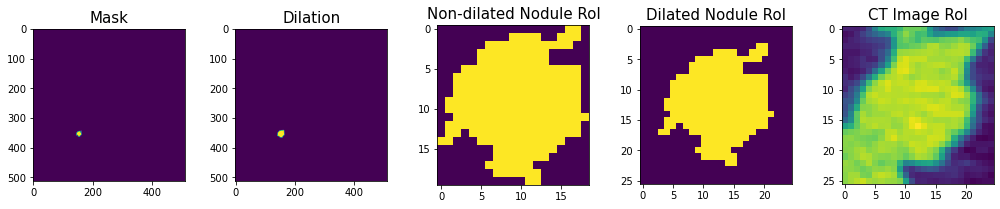

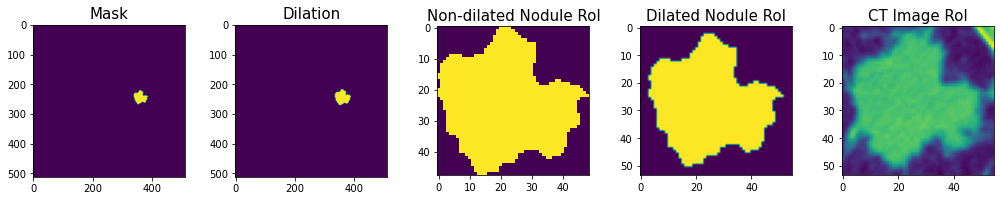

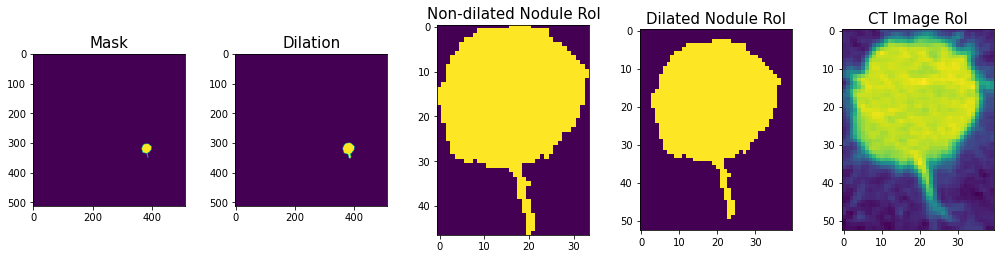

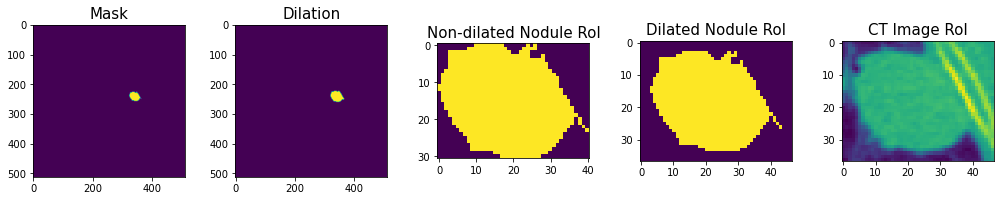

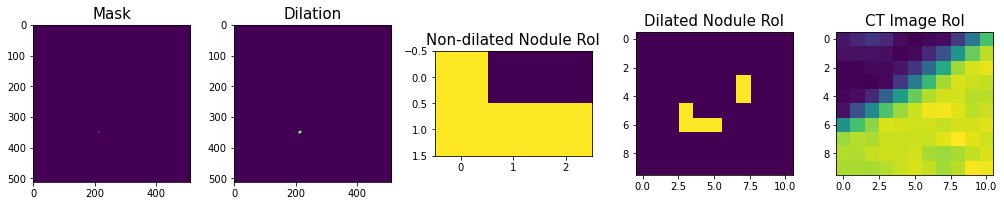

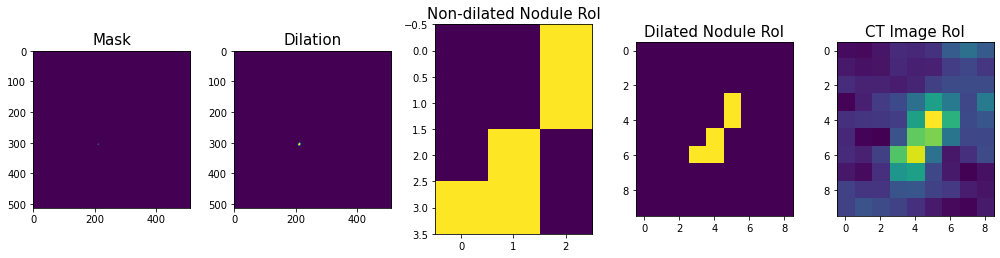

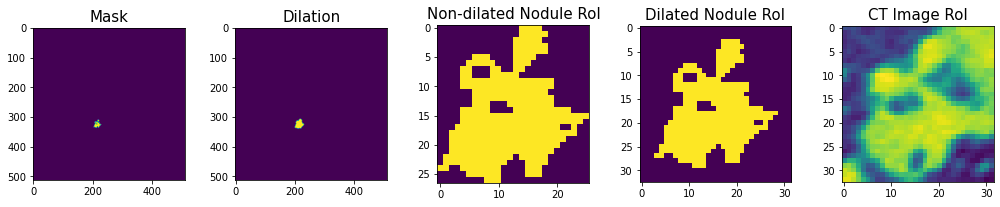

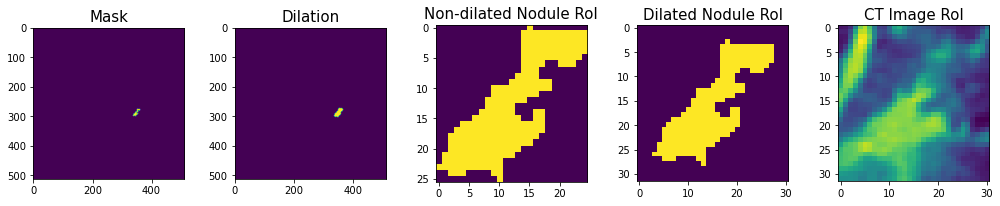

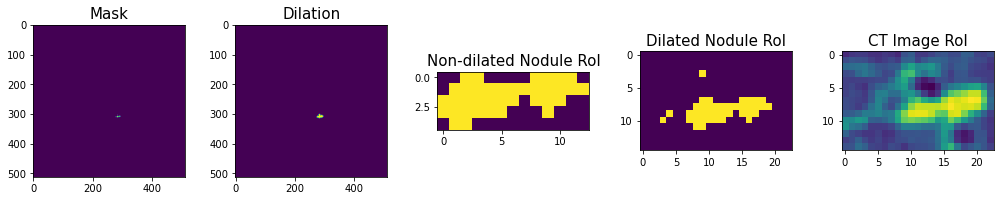

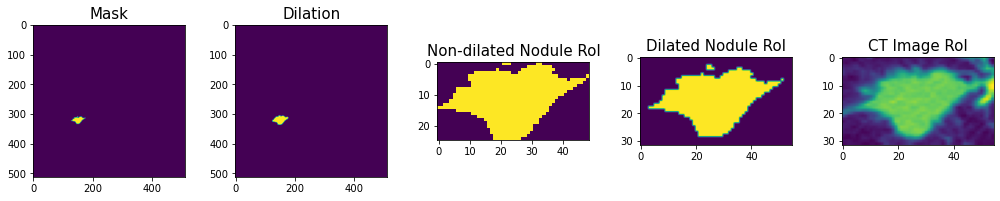

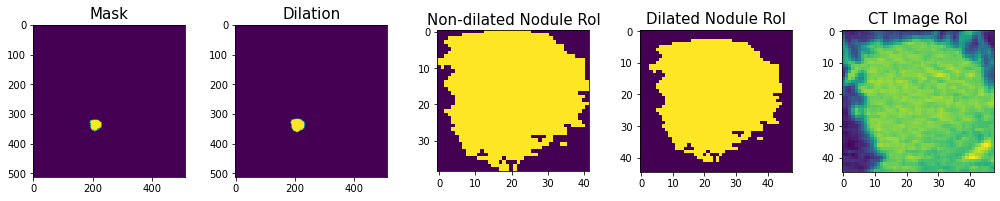

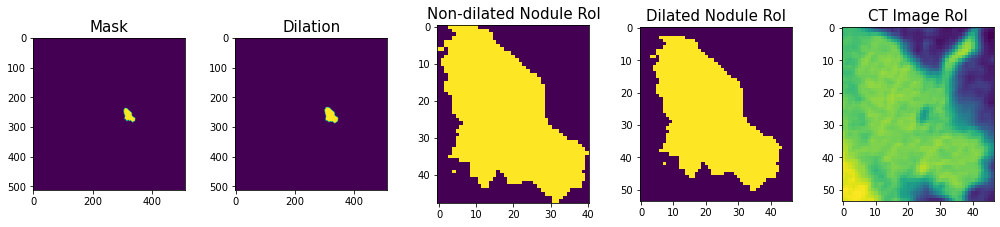

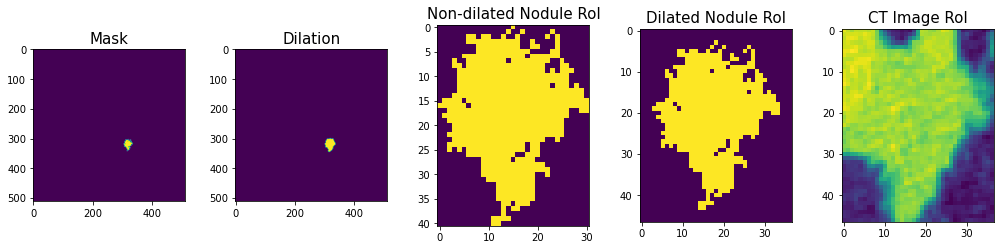

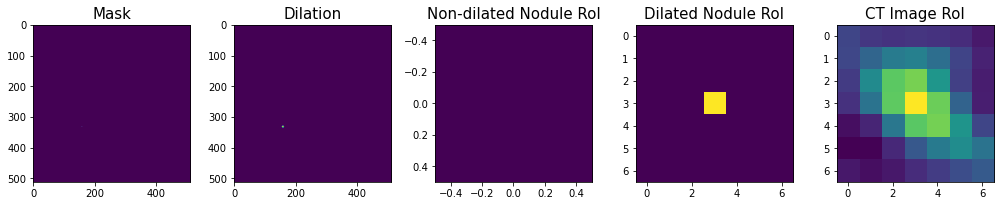

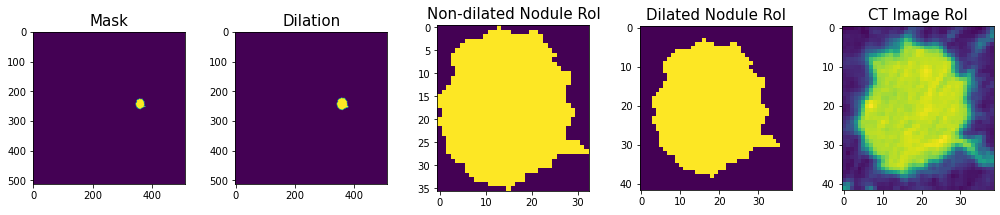

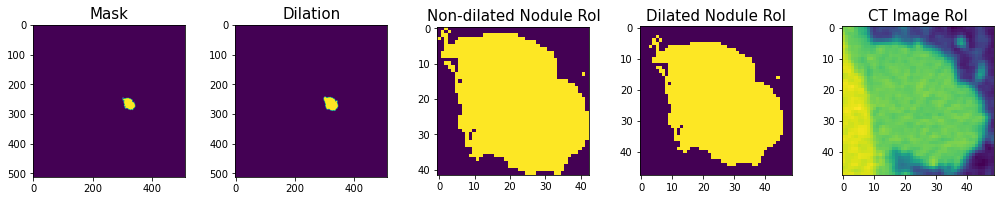

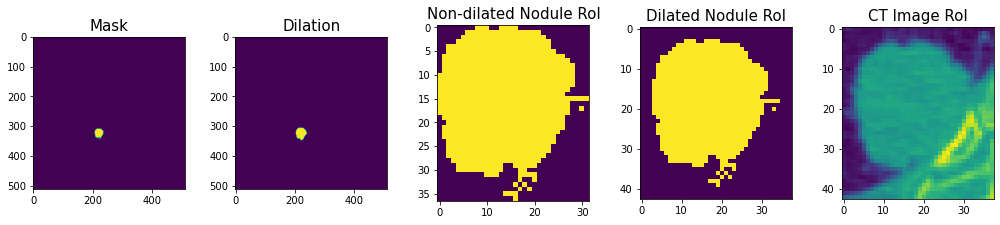

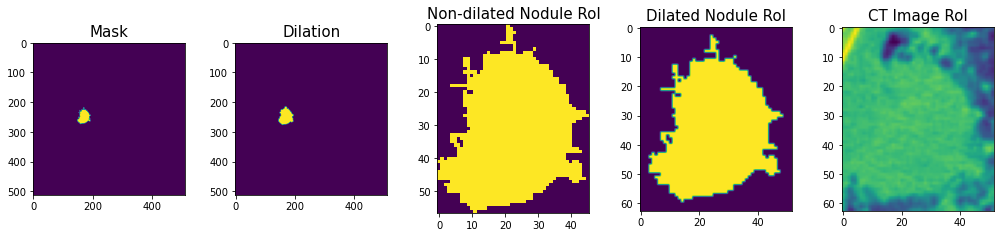

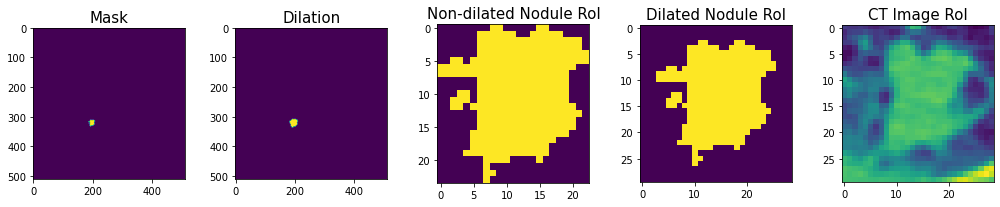

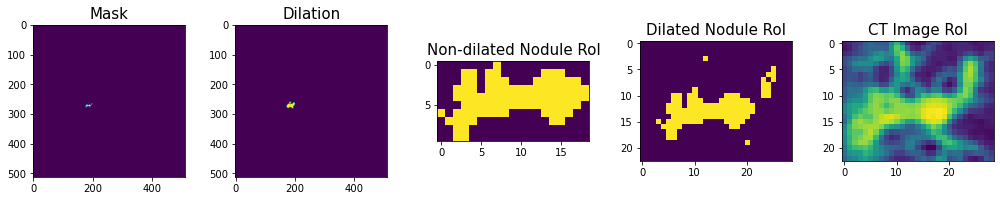

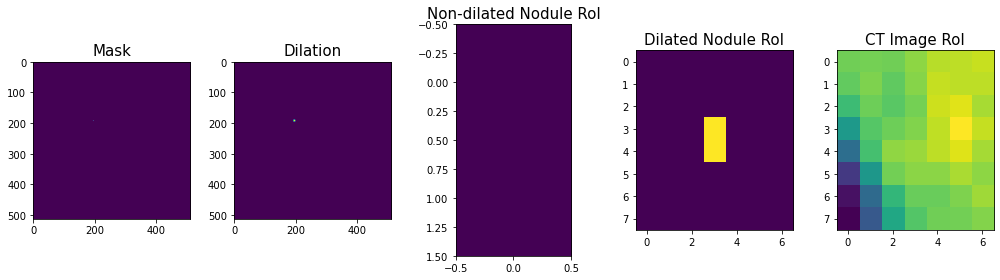

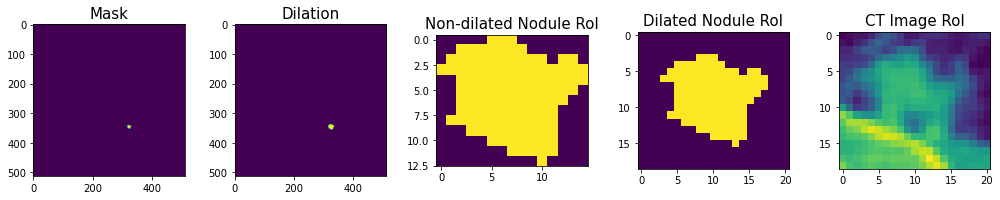

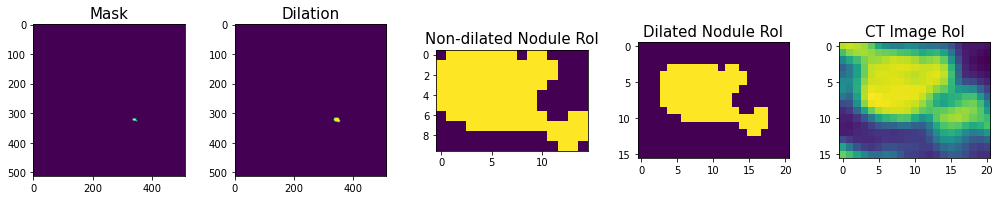

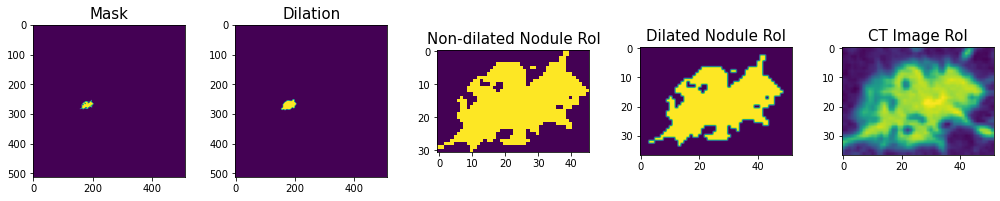

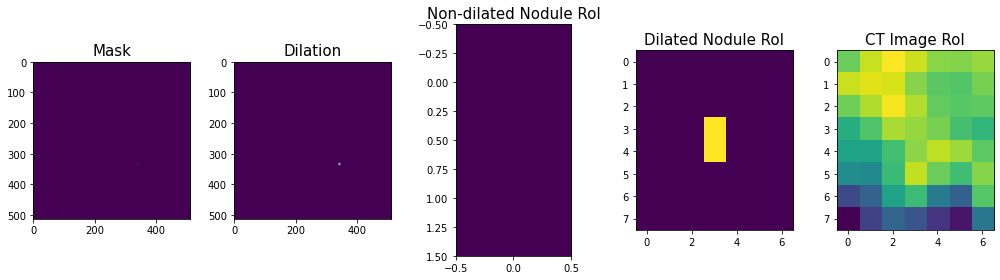

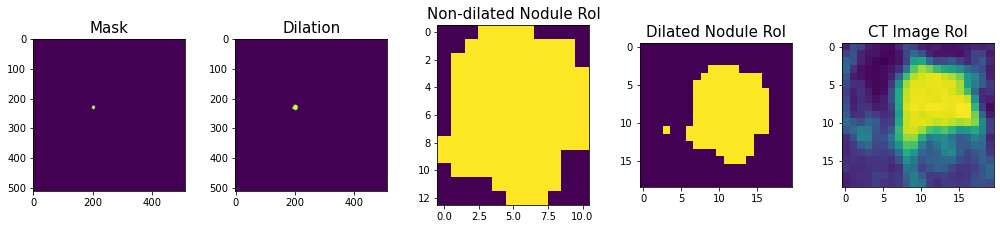

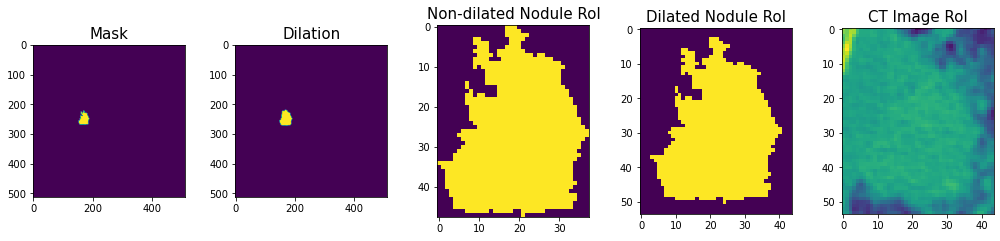

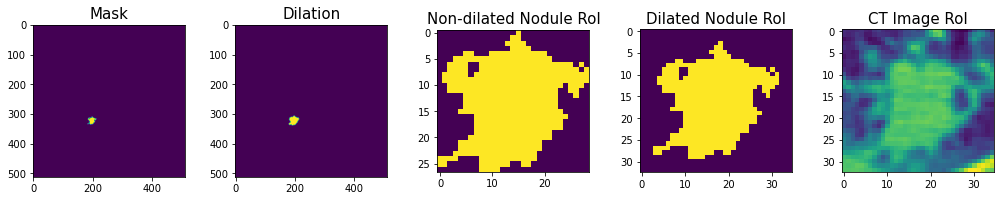

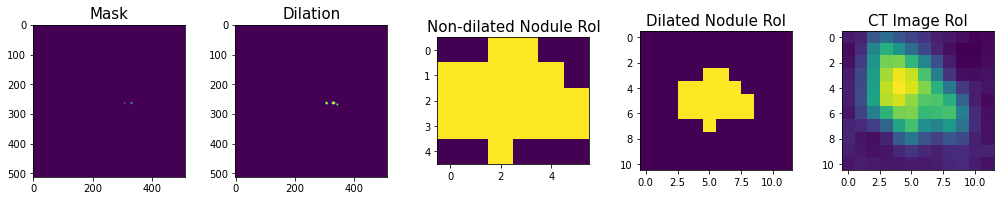

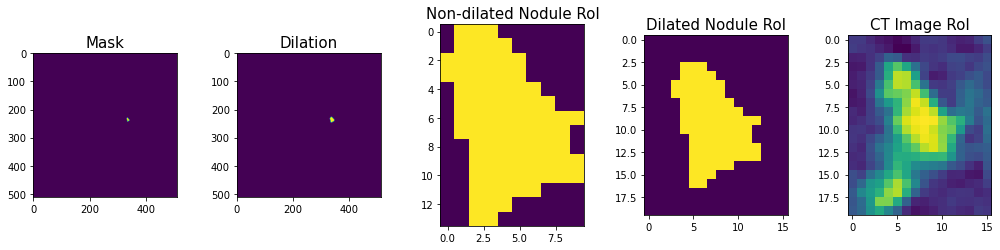

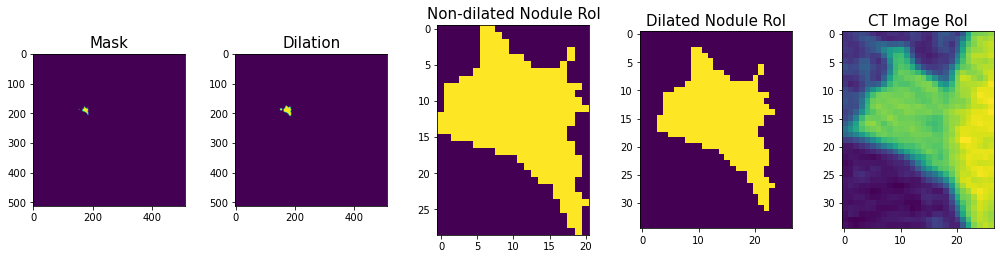

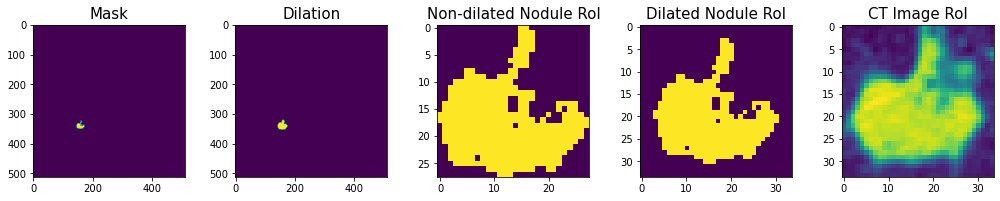

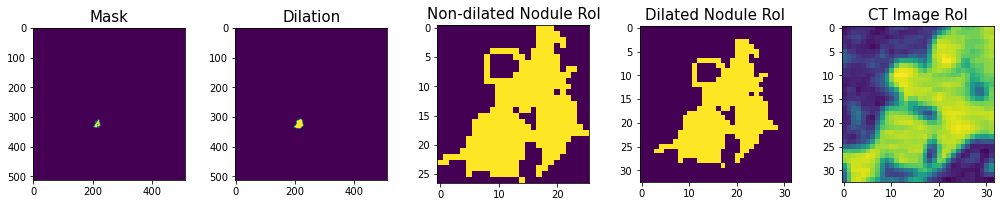

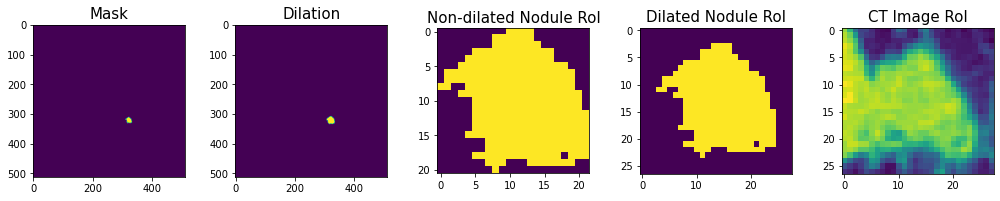

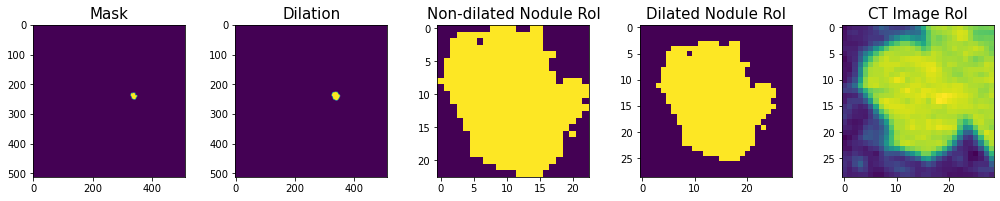

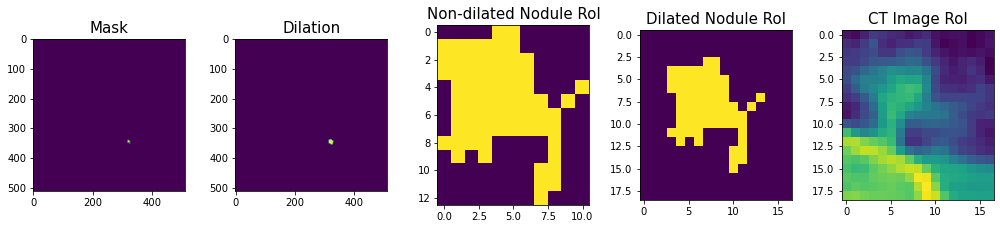

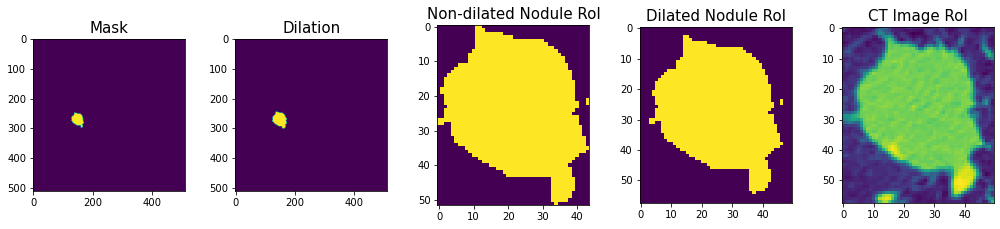

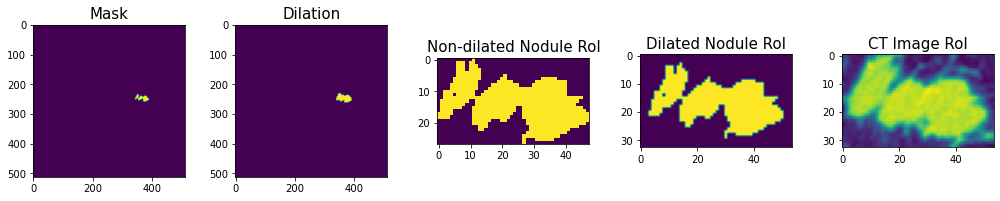

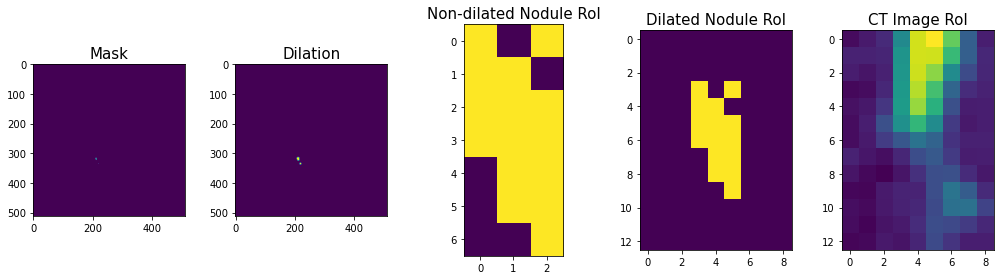

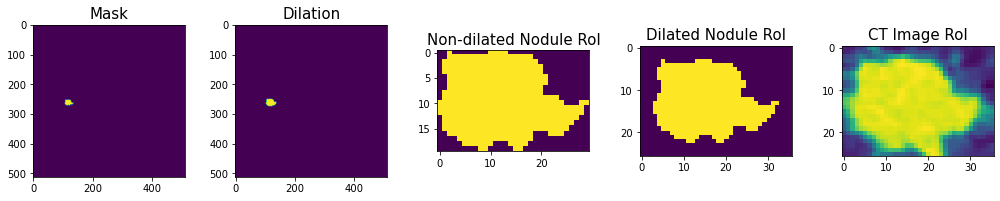

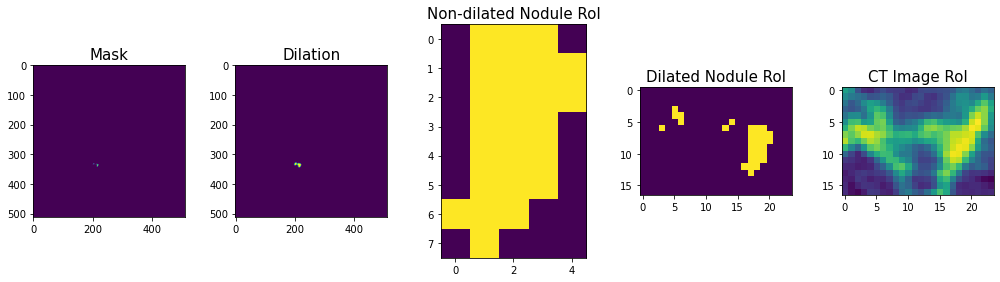

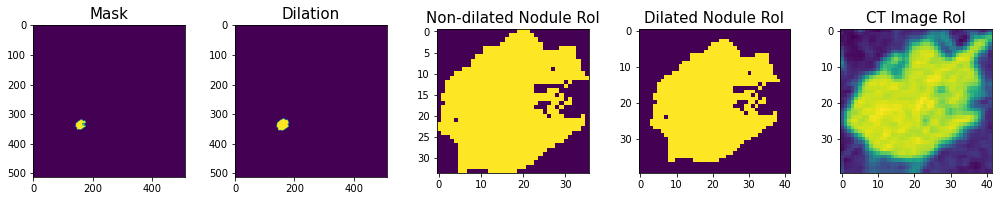

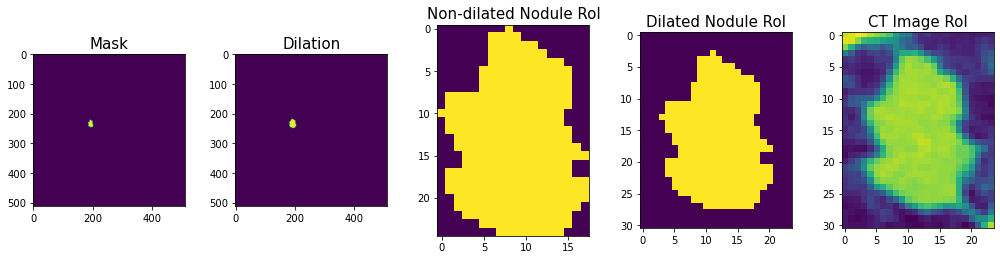

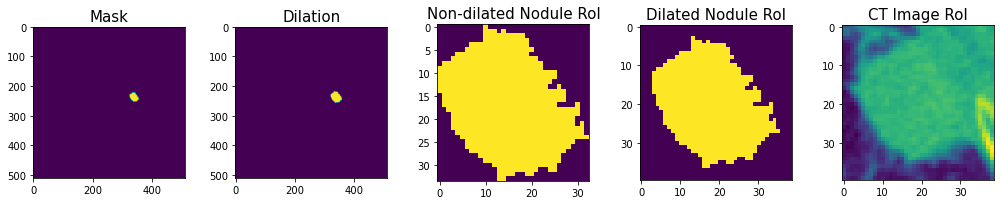

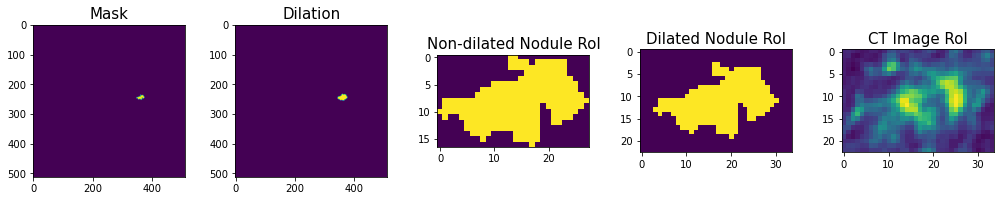

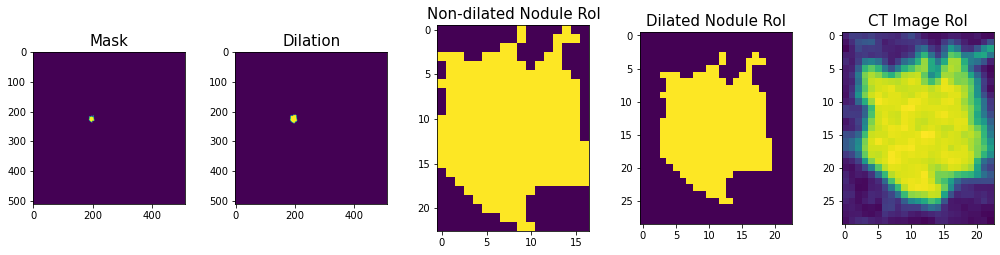

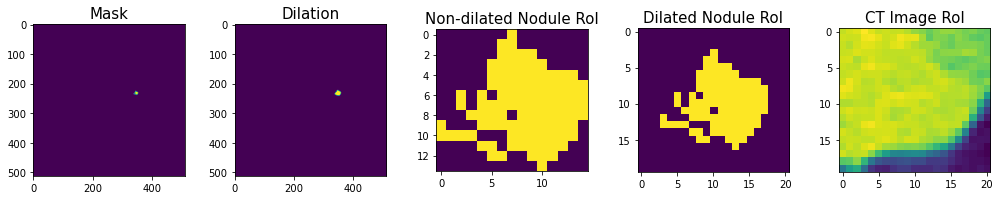

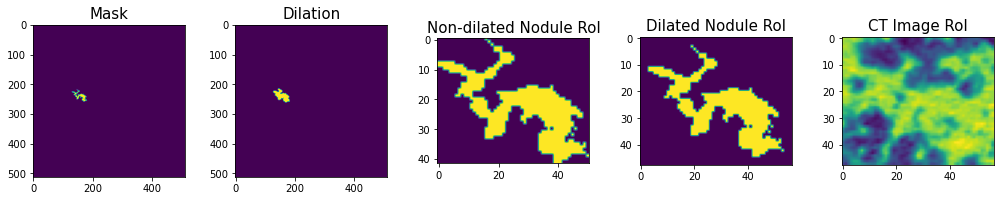

In [6]:
masks_dir = '/Storage/PauloOctavioDir/nodule_images/HCRP/masks/'
images_dir = '/Storage/PauloOctavioDir/nodule_images/HCRP/images/'
for mask_file in random.sample(os.listdir(masks_dir), 50):
    mask = get_pixel_array(masks_dir + mask_file)
    image = get_pixel_array(images_dir + mask_file)
    selem = disk(3)
    binary_dilated = binary_dilation(mask, selem)
    original_cropped_mask = mask_to_roi(mask, mask)
    dilated_cropped_mask = mask_to_roi(binary_dilated, mask)
    dilated_cropped_image = mask_to_roi(binary_dilated, image)
    show_image_list(
        [mask, binary_dilated, original_cropped_mask, dilated_cropped_mask, dilated_cropped_image],
        ['Mask', 'Dilation', 'Non-dilated Nodule RoI', 'Dilated Nodule RoI', 'CT Image RoI'],
        figsize=(14, 4),
        num_cols=5)

In [16]:
mask_resolutions = []
for mask_file in os.listdir(masks_dir):
    mask = get_pixel_array(masks_dir + mask_file)
    selem = disk(3)
    binary = binary_dilation(mask, selem)
    bbox = mask_to_bbox(binary)
    mask_resolutions.append(get_image_resolution(bbox))

In [ ]:
counts, bins, bars = plt.hist(mask_resolutions, cumulative=True, density=True, bins=range(0, int(max(mask_resolutions)),1))

In [ ]:
mean_size = np.mean(mask_resolutions)
print(F"The average tumor size is {mean_size:.0f}x{mean_size:.0f}")
print(f"A RoI of 43x43 can cover {counts[43]:.2%} of the tumors and a RoI of resolution 64x64 can cover {counts[64]:.2%} of the tumors.")

### NSCLC

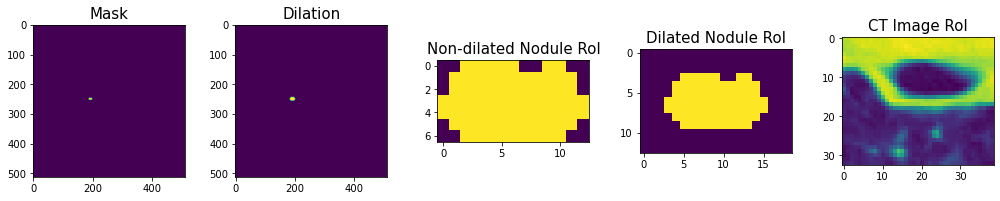

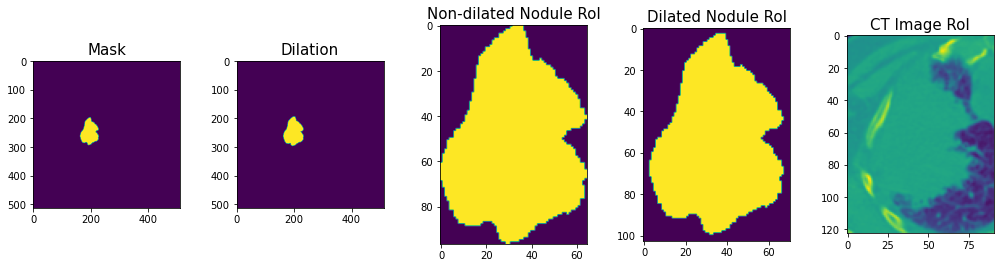

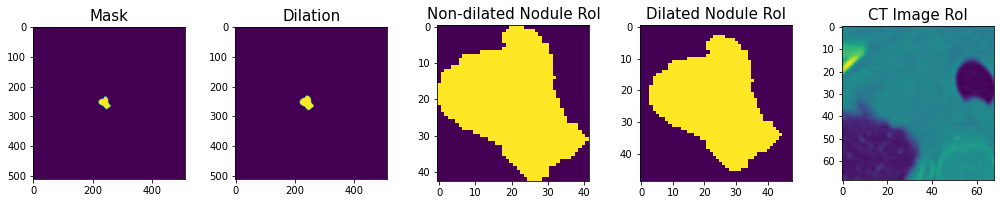

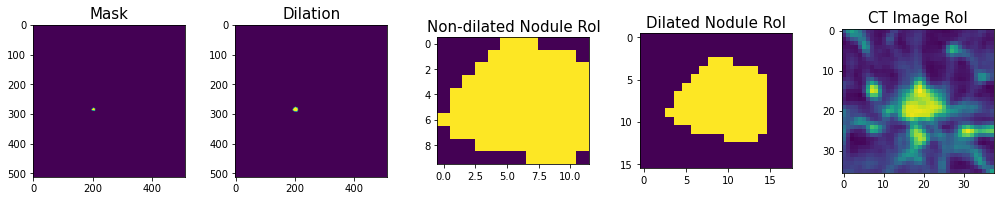

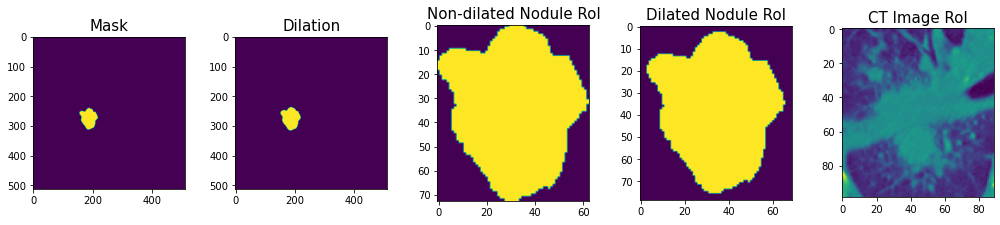

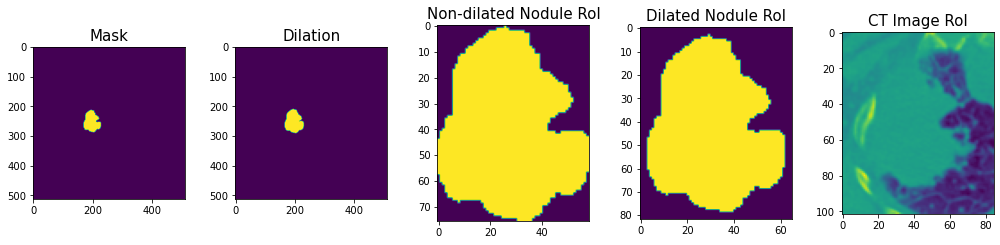

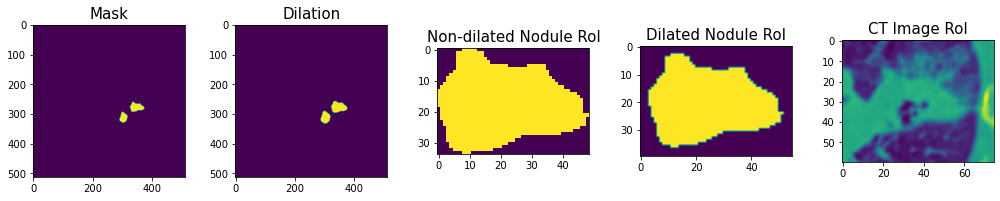

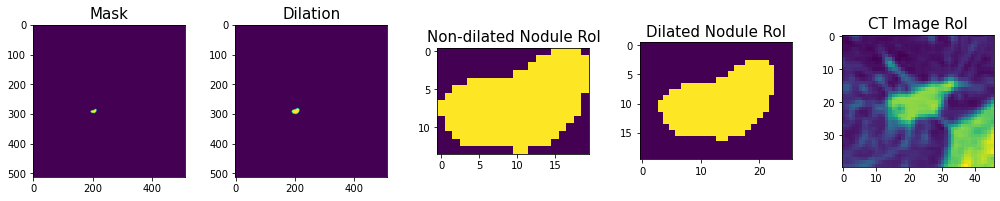

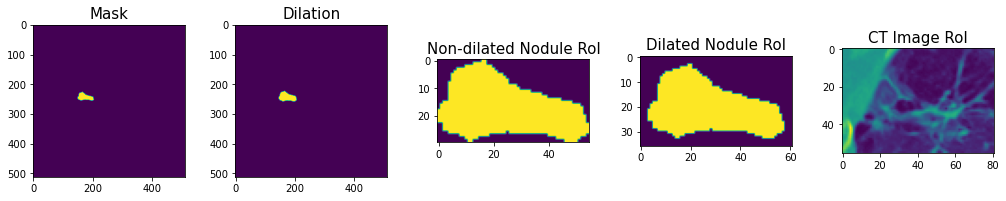

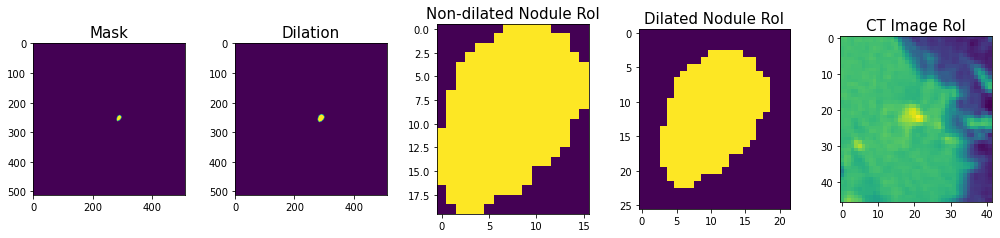

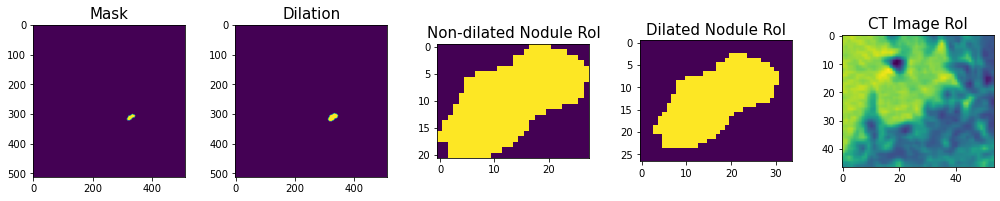

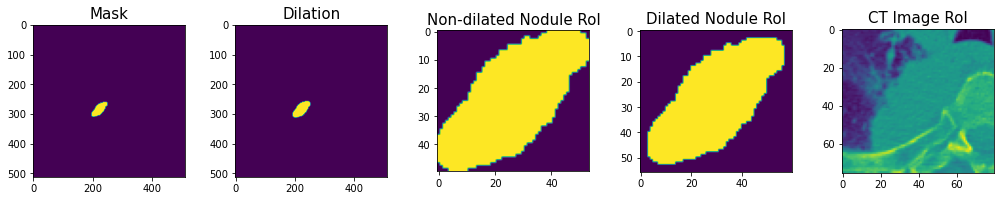

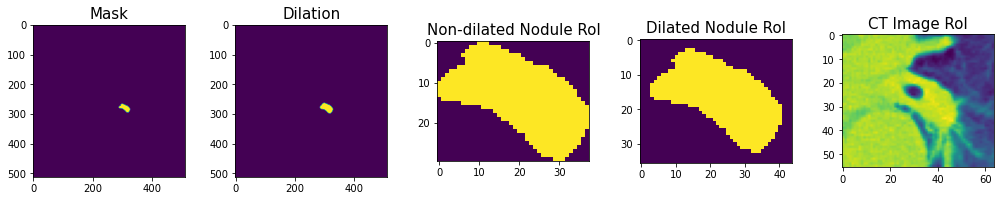

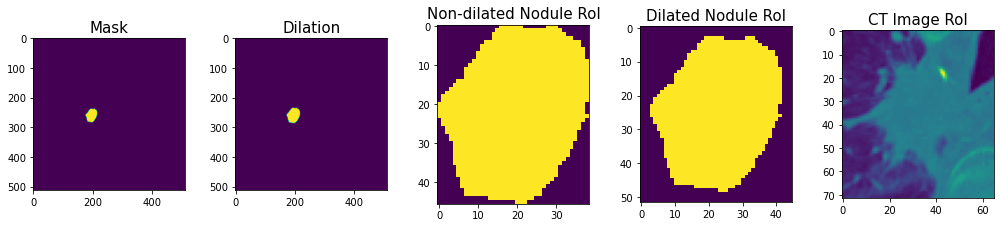

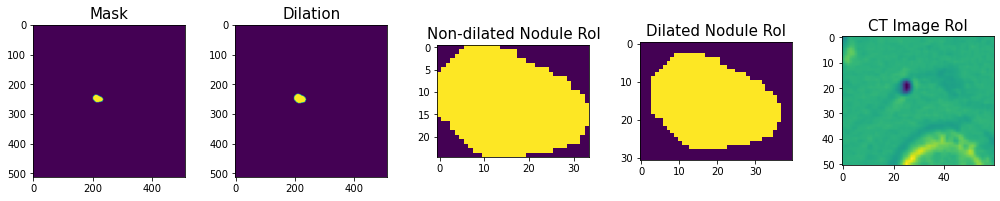

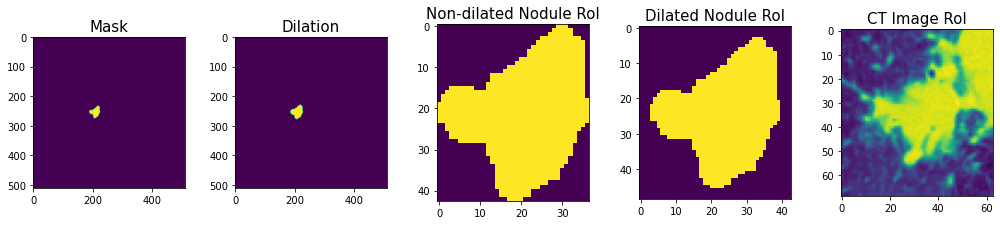

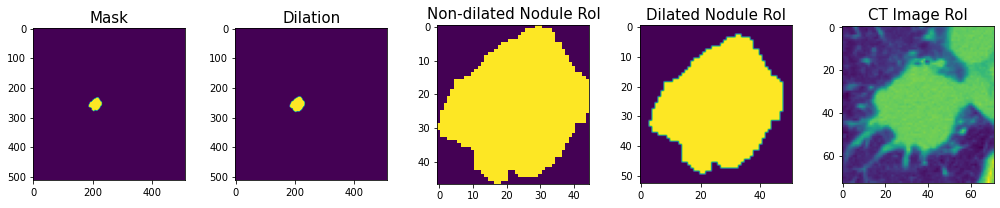

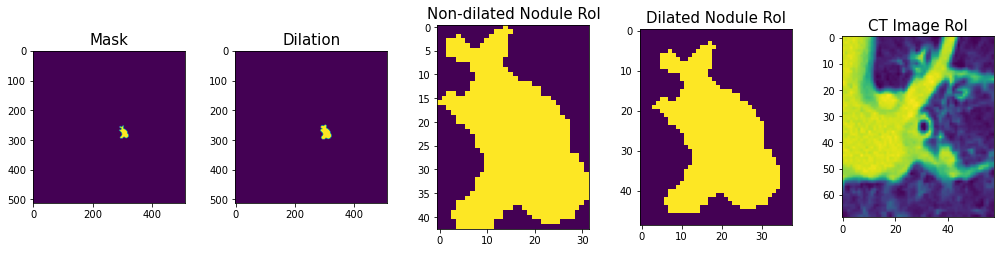

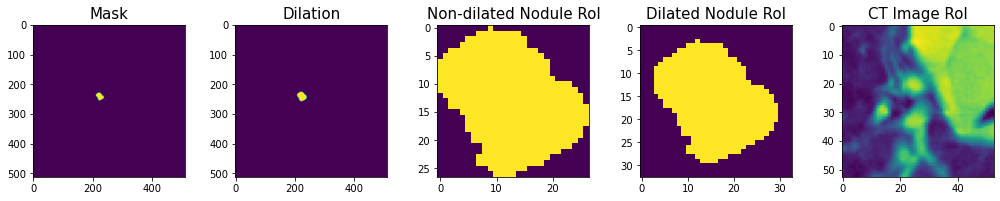

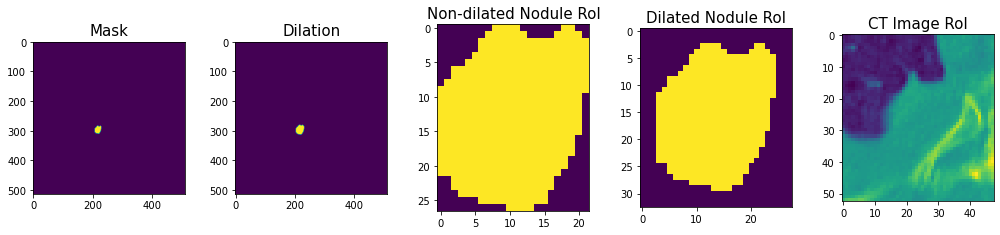

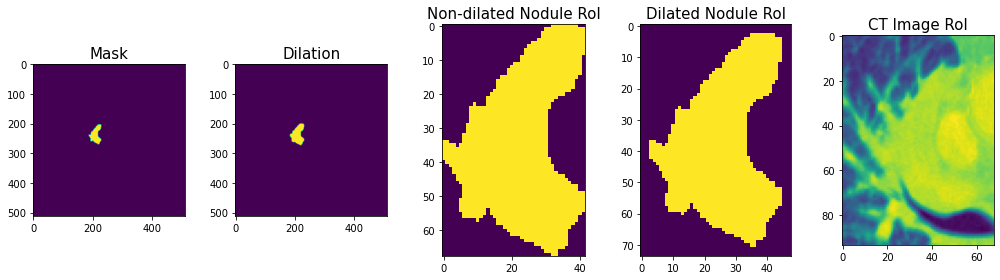

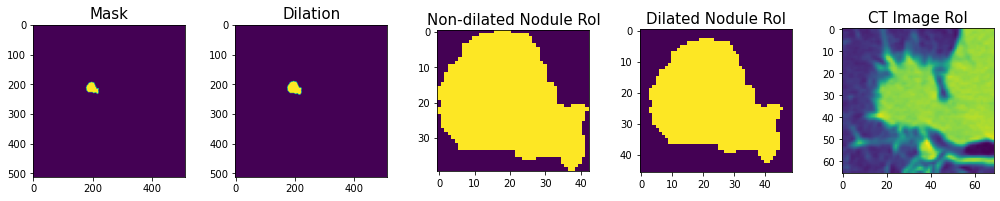

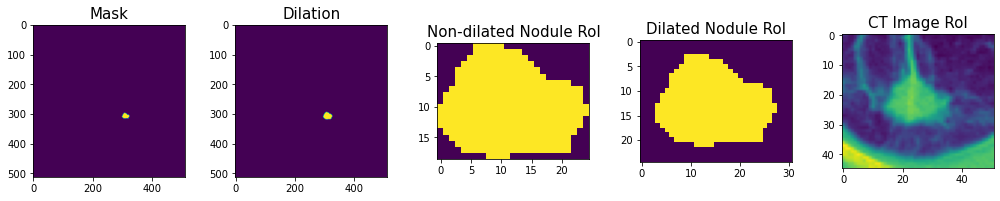

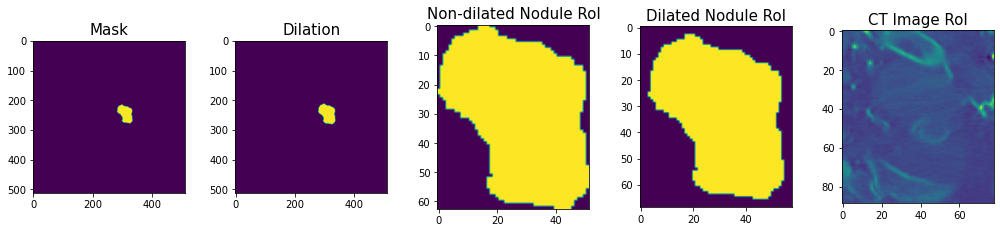

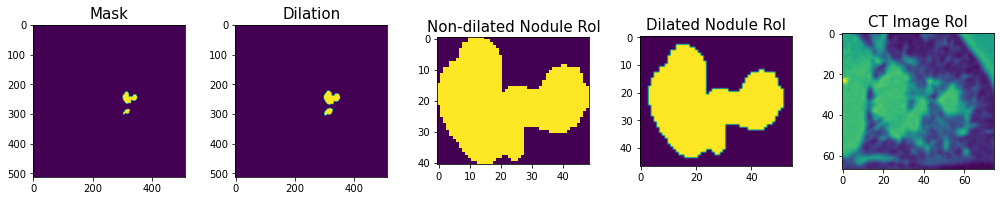

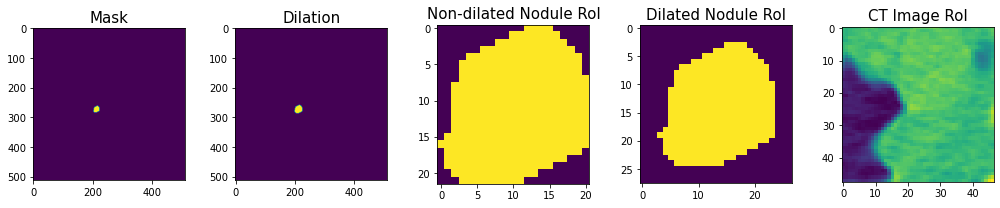

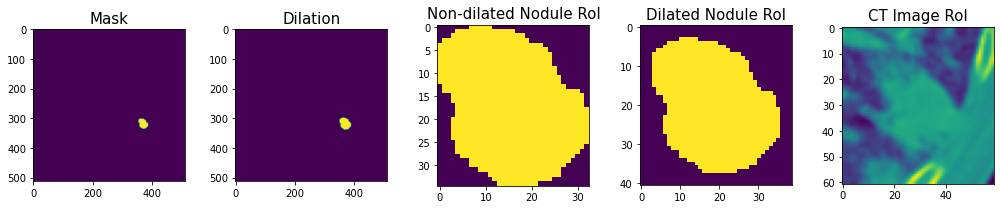

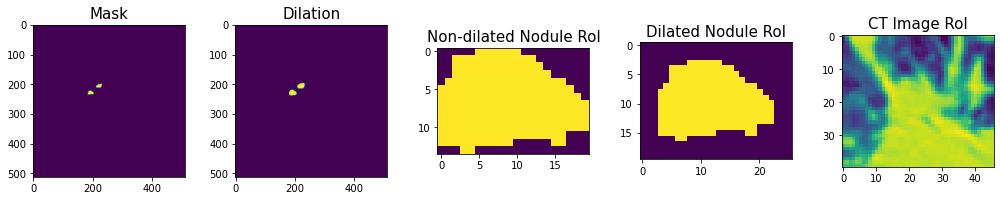

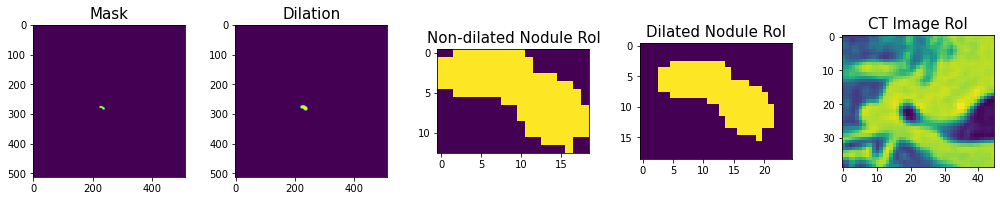

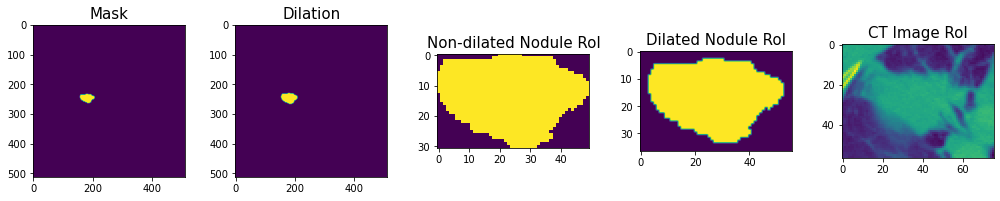

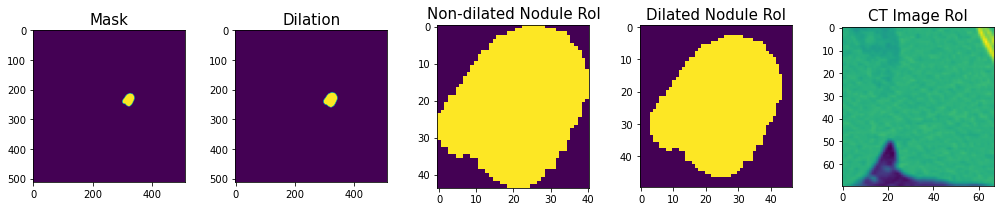

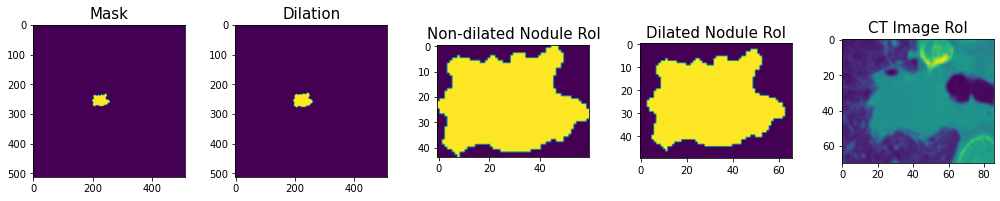

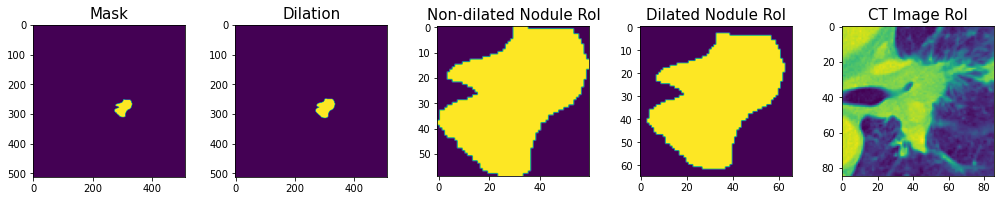

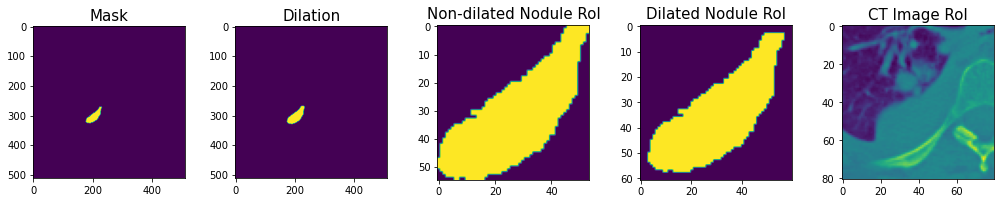

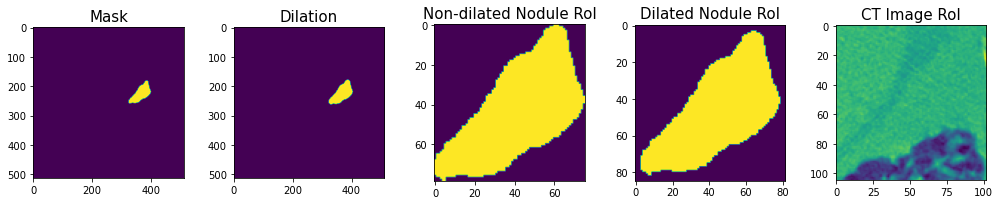

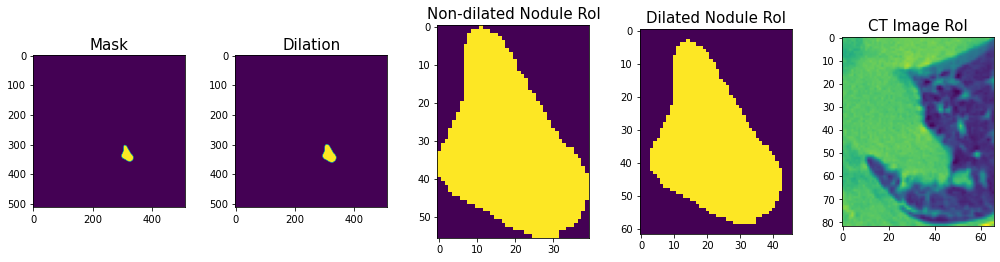

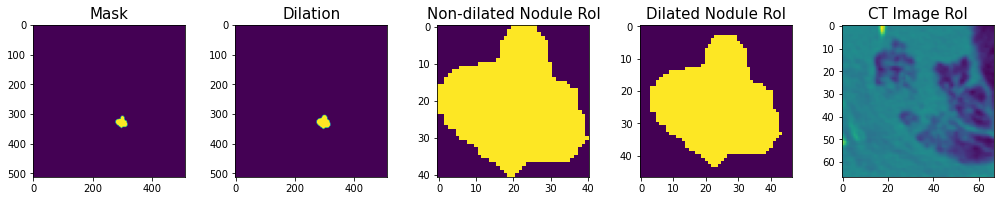

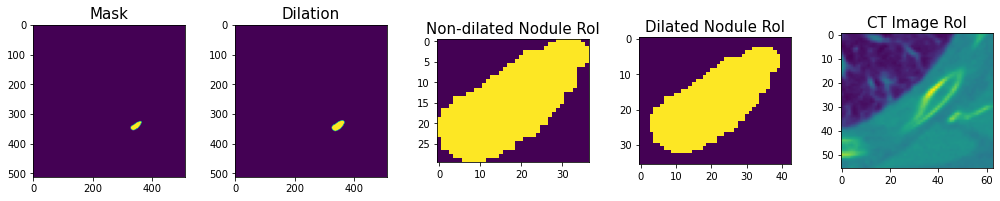

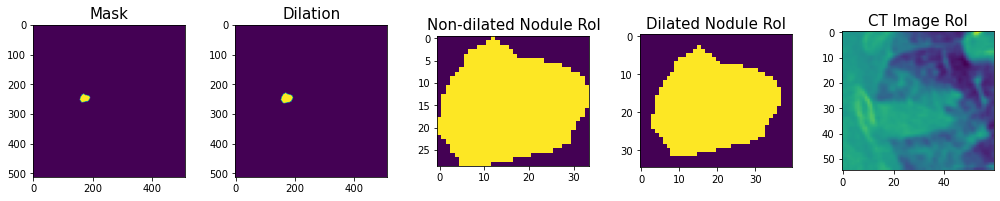

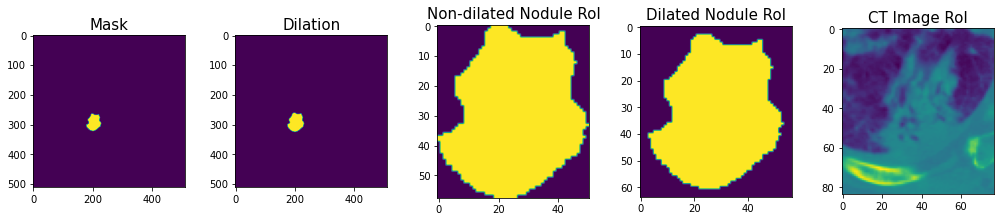

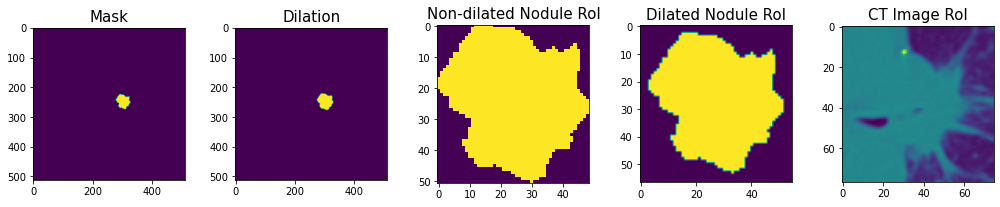

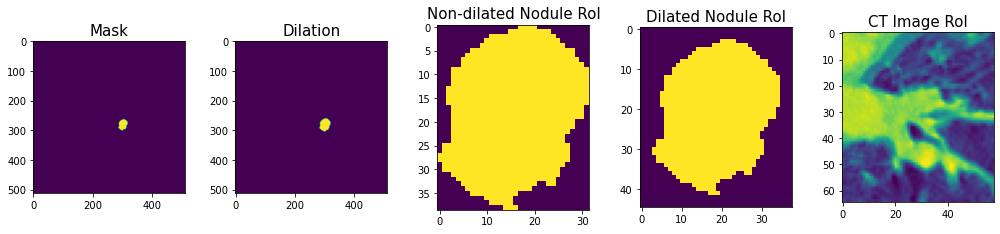

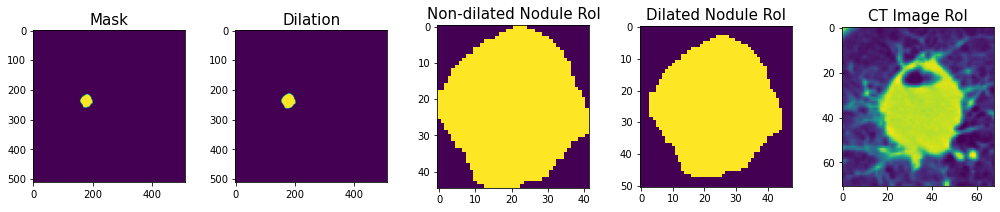

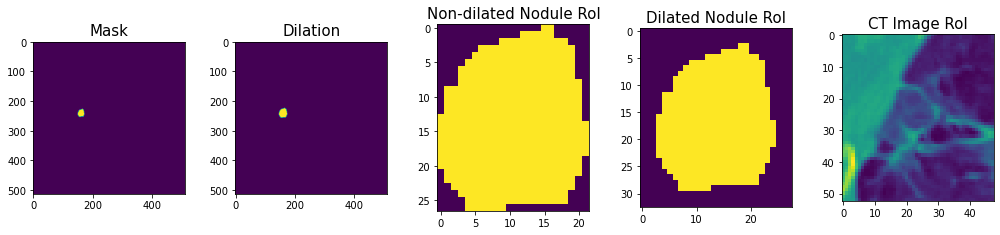

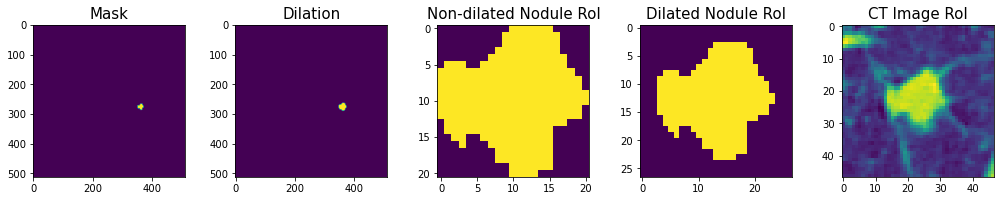

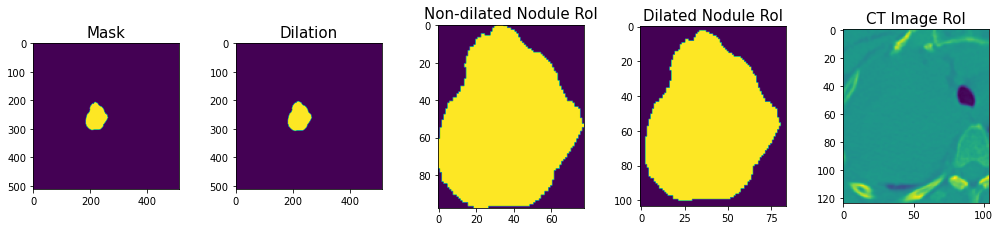

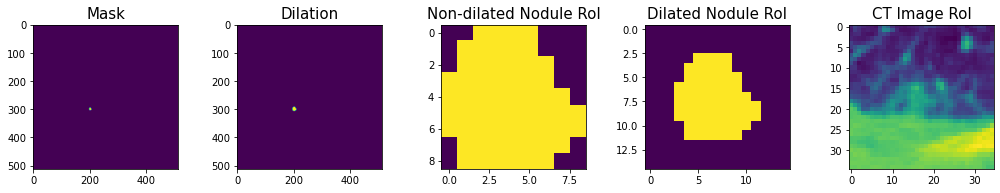

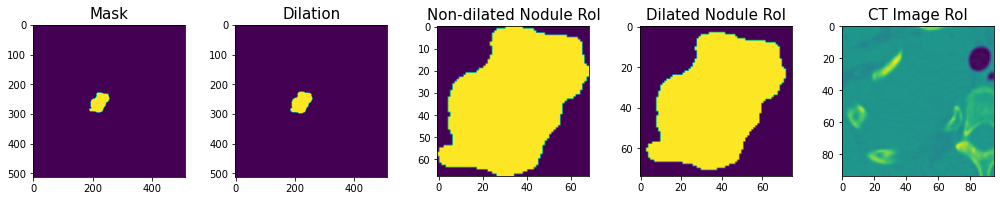

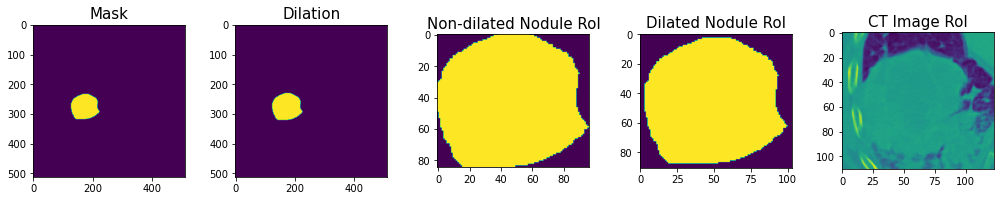

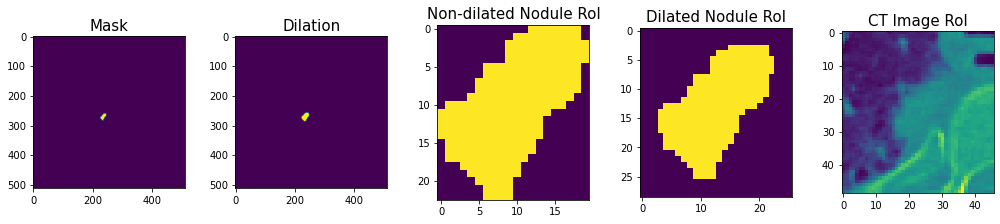

In [7]:
masks_dir = '/Storage/PauloOctavioDir/nodule_images/NSCLC/masks/'
images_dir = '/Storage/PauloOctavioDir/nodule_images/NSCLC/images/'

for mask_file in random.sample(os.listdir(masks_dir), 50):
    mask = get_pixel_array(masks_dir + mask_file)
    image = get_pixel_array(images_dir + mask_file)
    selem = disk(3)
    binary_dilated = binary_dilation(mask, selem)
    original_cropped_mask = mask_to_roi(mask, mask)
    dilated_cropped_mask = mask_to_roi(binary_dilated, mask)
    dilated_cropped_image = mask_to_roi(binary_dilated, image, bbox_extension=10)
    show_image_list(
        [mask, binary_dilated, original_cropped_mask, dilated_cropped_mask, dilated_cropped_image],
        ['Mask', 'Dilation', 'Non-dilated Nodule RoI', 'Dilated Nodule RoI', 'CT Image RoI'],
        figsize=(14, 4),
        num_cols=5)

In [ ]:
mask_resolutions = []
for mask_file in os.listdir(masks_dir):
    mask = get_pixel_array(masks_dir + mask_file)
    selem = disk(3)
    binary = binary_dilation(mask, selem)
    bbox = mask_to_bbox(binary)
    mask_resolutions.append(get_image_resolution(bbox))

In [ ]:
counts, bins, bars = plt.hist(mask_resolutions, cumulative=True, density=True, bins=range(0, int(max(mask_resolutions)),1))

In [ ]:
mean_size = np.mean(mask_resolutions)
print(F"The average tumor size is {mean_size:.0f}x{mean_size:.0f}")
print(f"A RoI of 64x64 can cover {counts[64]:.2%} of the tumors and a RoI of resolution 67x67 can cover {counts[67]:.2%} of the tumors.")

## Lung-PET-CT-Dx

In [2]:
LUNG_PET_CT_DX_IMG_DIR = "/Storage/PauloOctavioDir/Lung-PET-CT-Dx/Images/"
LUNG_PET_CT_DX_ANT_DIR = "/Storage/PauloOctavioDir/Lung-PET-CT-Dx/Annotations/"

In [1]:
from xml.etree import ElementTree

class XML_preprocessor(object):

    def __init__(self, data_path, num_classes, normalize=False):
        self.path_prefix = data_path
        self.num_classes = num_classes
        self.normalization = normalize
        self.data = {}
        self._preprocess_XML()

    def _preprocess_XML(self):
        filenames = os.listdir(self.path_prefix)
        for filename in filenames:
            tree = ElementTree.parse(os.path.join(self.path_prefix, filename))
            root = tree.getroot()
            bounding_boxes = []
            one_hot_classes = []
            size_tree = root.find('size')
            width = float(size_tree.find('width').text)
            height = float(size_tree.find('height').text)
            for object_tree in root.findall('object'):
                for bounding_box in object_tree.iter('bndbox'):
                    if self.normalization:
                        xmin = float(bounding_box.find('xmin').text)/width
                        ymin = float(bounding_box.find('ymin').text)/height
                        xmax = float(bounding_box.find('xmax').text)/width
                        ymax = float(bounding_box.find('ymax').text)/height
                    else:
                        xmin = float(bounding_box.find('xmin').text)
                        ymin = float(bounding_box.find('ymin').text)
                        xmax = float(bounding_box.find('xmax').text)
                        ymax = float(bounding_box.find('ymax').text)
                bounding_box = [xmin,ymin,xmax,ymax]
                bounding_boxes.append(bounding_box)
                class_name = object_tree.find('name').text
                one_hot_class = self._to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)
            # image_name = root.find('filename').text
            image_name = filename
            bounding_boxes = np.asarray(bounding_boxes)
            one_hot_classes = np.asarray(one_hot_classes)
            image_data = np.hstack((bounding_boxes, one_hot_classes))
            self.data[image_name] = image_data
            
    def _to_one_hot(self, name):
        name = name.upper()
        one_hot_vector = [0] * self.num_classes
        if name == 'A':
            one_hot_vector[0] = 1
        elif name == 'B':
            one_hot_vector[1] = 1
        elif name == 'E':
            one_hot_vector[2] = 1
        elif name == 'G':
            one_hot_vector[3] = 1
        else:
            print('unknown label: %s' %name)

        return one_hot_vector

def getUID_path(path):
    UID_dict = {}
    file_list = os.listdir(path)

    for date in file_list:
        date_path = os.path.join(path, date)
        series_list = os.listdir(date_path)
        series_list.sort()

        for series in series_list:
            series_path = os.path.join(date_path, series)
            dicom_list = os.listdir(series_path)
            dicom_list.sort()

            for dicom in dicom_list:
                dicom_path = os.path.join(series_path, dicom)
                info = loadFileInformation(dicom_path)
                UID_dict[info['dicom_num']] = (dicom_path, dicom)
    return UID_dict


def getUID_file(path):
    info = loadFileInformation(path)
    UID = info['dicom_num']
    return UID

def crop_bbox(image, bbox, bbox_extension=0):
    cropped_image = image[
        bbox[1] - bbox_extension:bbox[3] + bbox_extension,
        bbox[0] - bbox_extension:bbox[2] + bbox_extension
    ]
    return cropped_image

def loadFileInformation(filename):
    information = {}
    ds = dicomio.read_file(filename, force=True)
    information['dicom_num'] = ds.SOPInstanceUID
    # information['PatientID'] = ds.PatientID
    # information['PatientName'] = ds.PatientName
    # information['PatientBirthDate'] = ds.PatientBirthDate
    # information['PatientSex'] = ds.PatientSex
    # information['StudyID'] = ds.StudyID
    # information['StudyDate'] = ds.StudyDate
    # information['StudyTime'] = ds.StudyTime
    # information['InstitutionName'] = ds.InstitutionName
    # information['Manufacturer'] = ds.Manufacturer
    # information['NumberOfFrames'] = ds.NumberOfFrames
    return information

In [23]:
files = []
for exam in sorted(os.listdir(LUNG_PET_CT_DX_IMG_DIR)):
    dicom_path = LUNG_PET_CT_DX_IMG_DIR + exam
    exam_id = exam.split('-')[1]
    annotation_path = LUNG_PET_CT_DX_ANT_DIR + exam_id
    UID_dict = getUID_path(dicom_path)
    annotations = XML_preprocessor(annotation_path, num_classes=4).data
    for UID, annot_data in sorted(annotations.items()):
        try:
            dcm_path, dcm_name = UID_dict[UID[:-4]]
        except:
            continue
        dicom_data = dcmread(dcm_path)
        conv_kernel = dicom_data.ConvolutionKernel
#         if conv_kernel in ['LUNG', 'L', 'B70f']:
        image = dicom_data.pixel_array
        intercept = int(dicom_data.RescaleIntercept)
        slope = int(dicom_data.RescaleSlope)
        image = (slope * image) + intercept
        rect = annot_data[0]
        x1 = int(rect[0])
        y1 = int(rect[1])
        x2 = int(rect[2])
        y2 = int(rect[3])
        bbox = [x1, y1, x2, y2]
        file_name = exam_id + '_' + dcm_path.split('/')[-1]
        image_roi = crop_bbox(image, bbox, 5)

#         plt.imshow(image_roi, vmin=-1000, vmax=400,)
#         plt.title(f"{file_name} - {conv_kernel}")
#         plt.show()
        hist_type = exam_id[0]
        hists = {
            'A': {'name': 'adeno', 'acronym': 'LUAD'}, 
            'G': {'name': 'squamous', 'acronym': 'LUSC'}
        }

        file_name = exam_id + '_' + dcm_path.split('/')[-1]
        image_dest_fpath = (f"LPET_{hists[hist_type]['acronym']}_{file_name}")
        if image_dest_fpath not in files:
            files.append(image_dest_fpath)

unknown label: Q
unknown label: Q
unknown label: Q
unknown label: Q
unknown label: Q
unknown label: Q
unknown label: Q
unknown label: Q
unknown label: Q
unknown label: Q


In [ ]:
# path to the folder stored annotation files (.xml) or a path to a single annotation file
ANNOTATION_PATH = '/Storage/PauloOctavioDir/Lung-PET-CT-Dx/Annotations/A0071'
# path to the folder stored dicom files (.DCM)
DICOM_PATH = '/Storage/PauloOctavioDir/Lung-PET-CT-Dx/Images/Lung_Dx-A0071'
LABEL_LIST = ['LUAD', 'SCLC', 'LLCC', 'LUSC']

In [ ]:
UID_dict = getUID_path(DICOM_PATH)
annotations = XML_preprocessor(ANNOTATION_PATH, num_classes=4).data
for UID, annot_data in annotations.items():
    # dcm_name = k + '.dcm'
    dcm_path, dcm_name = UID_dict[UID[:-4]]
    image = get_pixel_array(dcm_path)
    
    rect = annot_data[0]
    x1 = int(rect[1])
    y1 = int(rect[0])
    x2 = int(rect[3])
    y2 = int(rect[2])
    bbox = [x1, y1, x2, y2]
    image_roi = crop_bbox(image, bbox, 5)
    
    label_array = rect[4:]
    index = int(np.where(label_array == np.float(1))[0])
    label = LABEL_LIST[index]


## Comparison Between Datasets

In [4]:
IMAGES_PATH = "/Storage/PauloOctavioDir/nodule_rois/gan/adeno/images/"

In [5]:
def get_windowed_hu(file):
    dicom_data = dcmread(file)
    image = dicom_data.pixel_array
    # Conversio to HU
    intercept = int(dicom_data.RescaleIntercept)
    slope = int(dicom_data.RescaleSlope)
    image = (slope * image) + intercept
    return image

In [6]:
LPET_adeno_images = np.concatenate(
    [get_windowed_hu(IMAGES_PATH + file).flatten() for file in os.listdir(IMAGES_PATH) if file.startswith('LPET')]
)
NSCLC_adeno_images = np.concatenate(
    [get_windowed_hu(IMAGES_PATH + file).flatten() for file in os.listdir(IMAGES_PATH) if file.startswith('NSCLC')]
)
HCRP_adeno_images = np.concatenate(
    [get_windowed_hu(IMAGES_PATH + file).flatten() for file in os.listdir(IMAGES_PATH) if file.startswith('HCRP')]
)

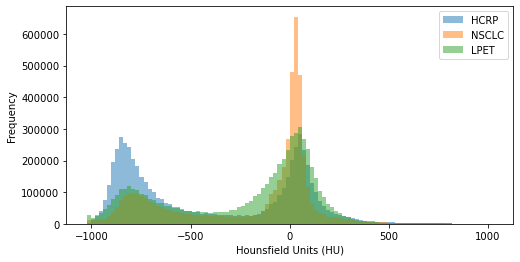

In [36]:
images = [HCRP_adeno_images, NSCLC_adeno_images, LPET_adeno_images]
titles = ["HCRP", "NSCLC", "LPET"]
plt.figure(figsize=(8,4))
for i, (data, title) in enumerate(zip(images, titles)):
    plt.hist(data, bins=100, alpha=.5, range=(-1024,1024), label=title)
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_dataset_count(hist_type):
    dataset_count = {'HCRP': 0, 'NSCLC': 0, 'LPET': 0, 'GAN': 0}
    for file in os.listdir(f"/Storage/PauloOctavioDir/nodule_rois/gan/{hist_type}/images/"):
        dataset = file.split("_")[0]
        dataset_count[dataset] +=1
    return dataset_count
print(get_dataset_count('adeno'))
print(get_dataset_count('squamous'))

In [ ]:
def get_study_count(hist_type):
    dataset_count = {'HCRP': [], 'NSCLC': [], 'LPET': []}
    path = f"/Storage/PauloOctavioDir/nodule_rois/gan/{hist_type}/images/"
    for file in os.listdir(path):
        dataset = file.split("_")[0]
        study = file.split("_")[2]
        if study not in dataset_count[dataset]:
            dataset_count[dataset] += [study]
    
    return dataset_count
study_count_adeno = get_study_count('adeno')
study_count_squamous = get_study_count('squamous')

In [ ]:
for key, value in study_count_adeno.items():
    print(key, len([item for item in value if item]))

In [ ]:
for key, value in study_count_squamous.items():
    print(key, len([item for item in value if item]))

In [4]:
def get_slice_thickness(hist_type):
    dataset_count = {'HCRP': [], 'NSCLC': [], 'LPET': []}
    path = f"/Storage/PauloOctavioDir/nodule_rois/gan/{hist_type}/images/"
    for file in os.listdir(path):
        dicom_data = dcmread(path + file)
        try:
            slice_thickness = dicom_data.SliceThickness
        except:
            continue
        dataset = file.split("_")[0]
        dataset_count[dataset] += [slice_thickness]
    return dataset_count

get_slice_thickness('adeno')

{'HCRP': ['1.0',
  '1.0',
  '1.0',
  '1.25',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.25',
  '1.0',
  '1.0',
  '1.428571',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.25',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '0.5',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '0.5',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.25',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  '1.0',
  